In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import h5py

from scipy.ndimage import gaussian_filter

!pip install lmfit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import auth

auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()

gc = gspread.authorize(creds)

Read Data

In [ ]:
worksheet = gc.open_by_key("1yuJgKXeS2OeKU235OMXS8dfLSKPl9ZA3VEYHmU7L3tA").sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df["Batch No."] = df["Batch No."].apply(pd.to_numeric)
df

,Batch No.,Identifier UUID,Sample #,Batch Fab Date,Batch Start Time,Perovskite composition,Additive,Additive Conc. (%mol excess),Soln date,Solution 1,...,PL Peak Intensity Std Dev,PL Peak Intensity Mean,PL Peak Center Std Dev,PL Peak Center Mean,PL Peak FWHM Std Dev,PL Peak FWHM Mean,XRD Alpha Peak Intensity,XRD Alpha Peak Center,XRD Alpha Peak FWHM,XRD Phase Score
0,1,,1,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
1,1,,2,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
2,1,,3,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
3,1,,4,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
4,1,,5,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,92,,3,2024-10-18,4.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,615694.2505,29.7E+6,0.0001834593589,1.54512127,0.0003528272249,0.08485524337,,,,
513,92,,4,2024-10-18,4.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,456555.6563,31.5E+6,0.0001113338965,1.543450222,0.0002268081831,0.08742468033,,,,
514,93,,1,2024-10-21,5.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,350874.9768,13.2E+6,0.0001031452625,1.537515048,0.0000872425146,0.08640677132,,,,
515,93,,2,2024-10-21,5.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,16348.37671,779.9E+3,0.001855950579,1.539890256,0.0005177045062,0.08719011624,,,,


In [ ]:
# define a function that grabs spec_run h5 file for a given sample row

data_dir = "/content/drive/Shareddrives/SpinBot/PEROVSKITE reproducibility project/Data/In line characterization"

data_dir_Abby = (
    "/content/drive/Shareddrives/SpinBot/SolventMixing/Data/In line characterization"
)


def get_spec_run_filepath(sample_row):
    spec_run_fname_short = list(sample_row["spec_run"])[0]
    if spec_run_fname_short == "":
        return None
    # ipdb.set_trace()
    main_path = glob.glob(data_dir + f"/*/{spec_run_fname_short}")
    if main_path == []:
        main_path = glob.glob(data_dir_Abby + f"/*/{spec_run_fname_short}")
    if main_path == []:
        main_path = glob.glob(data_dir_Abby + f"/*/*/{spec_run_fname_short}")
    if main_path == []:
        return None
    # ipdb.set_trace()

    spec_run_fname = main_path[0]
    return spec_run_fname

**START HERE FOR DATA PROCESSING**

In [ ]:
def find_nearest(array, value):
    """Find the index of the nearest value in an array."""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def index_of(arrval, value):
    """Return index of array *at or below* value."""
    if value < min(arrval):
        return 0
    return max(np.where(arrval <= value)[0])


def wavelength_to_energy(wavelength_nm):
    energy_eV = 1240 / wavelength_nm
    return energy_eV


def apply_jacobian(signal, wavelength_nm):
    energy_eV = wavelength_to_energy(wavelength_nm)
    jacobian = (1240) / (energy_eV**2)
    transformed_signal = signal * jacobian
    return transformed_signal

In [ ]:
#### AFTER RUNING HELPER FUNCTIONS, START HERE FOR UV-Vis (WL)

from scipy.stats import linregress

# for b in {61, 62, 63, 64, 65, 66}:
for b in range(88, 94, 1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {2}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            """
        WL Analysis
        """

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            # plt.figure()
            # plt.plot(wl_wave_axis, sample_spectrum_final, label=f'Sample Transmission Spectrum, Batch {b}, Sample {s}')
            # plt.title(f'Sample Transmission Spectrum, Batch {b}, Sample {s}')
            # plt.xlabel('Wavelength (nm)')
            # plt.ylabel('Transmission')

            #
            wl0 = 550
            wl1 = 800
            int_slice = (wl_wave_axis >= wl0) & (wl_wave_axis <= wl1)

            integrated_transmittance = np.sum(sample_spectrum_final[int_slice])
            mean_transmittance = np.mean(sample_spectrum_final[int_slice])

            absorption_spectrum = -np.log(sample_spectrum_final)
            wl_energy_axis = wavelength_to_energy(wl_wave_axis)
            absorption_spectrum_jacobian = apply_jacobian(
                absorption_spectrum, wl_energy_axis
            )

            a_coefficient = absorption_spectrum * 2.303 / (0.00004)
            log_A = np.log(a_coefficient)

            # CHANGE THIS NUMBERS IF THE ABSORPTION EDGE IS OUT OF RANGE
            energy_boundaries = np.array([1.4, 1.7])
            energies_range = (wl_energy_axis >= energy_boundaries[0]) & (
                wl_energy_axis <= energy_boundaries[1]
            )

            energies_cut = wl_energy_axis[energies_range]
            signal_cut = absorption_spectrum_jacobian[energies_range]
            log_signal_cut = log_A[energies_range]

            # Additonal functions

            def find_best_linear_region(
                x_data, y_data, window_min, window_max, r_squared_threshold
            ):
                best_start = 0
                best_end = window_min
                best_r_squared = 0
                best_slope = 0
                best_intercept = 0

                for window_size in range(window_min, window_max + 1):
                    for start in range(len(x_data) - window_size + 1):
                        end = start + window_size
                        x = x_data[start:end]
                        y = y_data[start:end]
                        r_squared, slope, intercept = linear_fit(x, y)

                        if (
                            r_squared > best_r_squared
                            and r_squared >= r_squared_threshold
                            and slope > 0
                        ):
                            best_r_squared = r_squared
                            best_start = start
                            best_end = end
                            best_slope = slope
                            best_intercept = intercept

                return best_start, best_end, best_r_squared, best_slope, best_intercept

            def linear_fit(x_axis, y_axis):
                slope, intercept, r_value, _, _ = linregress(x_axis, y_axis)
                return r_value**2, slope, intercept

            # %%

            def perform_and_plot_linear_fit(
                x_data, y_data, window_min, window_max, r_squared_threshold, types
            ):
                best_start, best_end, best_r_squared, best_slope, best_intercept = (
                    find_best_linear_region(
                        x_data, y_data, window_min, window_max, r_squared_threshold
                    )
                )

                if best_r_squared < r_squared_threshold:
                    return 0, 0, 0, 0

                x_cut = energies_cut[best_start:best_end]
                window_size = best_end - best_start
                x_intercept = -best_intercept / best_slope

                # plt.figure()
                # plt.plot(x_data, y_data, label="Original Data")
                # plt.plot(x_cut, best_intercept + best_slope * x_cut, 'r', label="Linear Fit")
                # plt.axvline(energies_cut[best_start], color='g', linestyle='--')
                # plt.axvline(energies_cut[best_end-1], color='g', linestyle='--')
                # plt.legend()
                # plt.xlabel("X")
                # plt.ylabel("Y")
                # plt.title(f"Linear Region Fit, {types}, Batch {b}, Sample {s}")
                # save_plot(plt, save_dir, f'Linear_Region_Fit_{type}.png')

                return window_size, best_slope, x_intercept, best_r_squared

            # %%

            # =============================================================================
            # PERFORM AUTOMATED LINEAR FIT
            # =============================================================================

            window_lin, slope_lin, intercept_lin, r_sq_lin = (
                perform_and_plot_linear_fit(
                    energies_cut,
                    signal_cut,
                    window_min=55,
                    window_max=150,
                    r_squared_threshold=0.95,
                    types="Lin",
                )
            )
            if window_lin != 0:
                a = 1
                # print(f"The final window size used for the best linear fit was: {window_lin} (linear scale)")
                # print(f"The final slope of the best linear fit is: {slope_lin} (linear scale)")
                # print(f"The final x-intercept of the best linear fit is: {intercept_lin} (linear scale)")
                # print(f"The final R squared of the best linear fit is: {r_sq_lin} (linear scale)")
                print(
                    f"Batch {b}, Sample {s}, Window Size times Slope : {window_lin * slope_lin} (linear scale)"
                )
            else:
                a = 1
                print("No suitable linear region found. (linear scale)")

            window_log, slope_log, intercept_log, r_sq_log = (
                perform_and_plot_linear_fit(
                    energies_cut,
                    log_signal_cut,
                    window_min=70,
                    window_max=150,
                    r_squared_threshold=0.95,
                    types="Log",
                )
            )
            if window_log != 0:
                # print(f"The final window size used for the best linear fit was: {window_log} (log scale)")
                # print(f"The final slope of the best linear fit is: {slope_log} (log scale)")
                # # print(f"The final x-intercept of the best linear fit is: {intercept_log} (log scale)")
                # # print(f"The final R squared of the best linear fit is: {r_sq_log} (log scale)")
                # print(f"Window Size times Slope : {window_log*slope_log} (log scale)")

                # print('Urbach Energy is', round(1/intercept_log, 4), 'eV')
                urbach_energy = round(1 / slope_log, 4)
                # # print('Urbach Energy is', round(1/slope_log, 4), 'eV')
            else:
                print("No suitable linear region found. (log scale)")
                urbach_energy = None

            print(f"Batch {b}, Sample {s}: {mean_transmittance=}")
            print(f"Batch {b}, Sample {s}: {urbach_energy=}")

            uuid = list(sample["Identifier UUID"])[0]

            # Find the row in the DataFrame where the UUID matches
            # row_index = df[df['Identifier UUID'] == uuid].index[0]
            row_index = df[df["spec_run"].str.contains(file_path.split("/")[-1])].index[
                0
            ]

            col_index_urbach_energy = df.columns.get_loc("Urbach Energy")

            # Update the cell in the Google Sheet for PL_peak_intensity_std
            cell = worksheet.cell(
                row_index + 2, col_index_urbach_energy + 1
            )  # Add 1 to row and column indices for Google Sheets
            cell.value = urbach_energy
            worksheet.update_cell(
                row_index + 2, col_index_urbach_energy + 1, urbach_energy
            )

            # Get the column index for the 'Mean Transmittance' column
            col_index = df.columns.get_loc("Mean Transmittance")

            # Update the cell in the Google Sheet
            cell = worksheet.cell(
                row_index + 2, col_index + 1
            )  # Add 1 to row and column indices for Google Sheets
            cell.value = mean_transmittance
            worksheet.update_cell(row_index + 2, col_index + 1, mean_transmittance)

<ipython-input-7-454268e8b0b5>:54: RuntimeWarning: invalid value encountered in log
  absorption_spectrum = -np.log(sample_spectrum_final)
<ipython-input-7-454268e8b0b5>:59: RuntimeWarning: invalid value encountered in log
  log_A = np.log(a_coefficient)


Batch 88, Sample 1, Window Size times Slope : 2.0364989082339395 (linear scale)
Batch 88, Sample 1: mean_transmittance=0.08911246984808714
Batch 88, Sample 1: urbach_energy=0.1346
Batch 88, Sample 2, Window Size times Slope : 1.7918705247257956 (linear scale)
Batch 88, Sample 2: mean_transmittance=0.08488024290998927
Batch 88, Sample 2: urbach_energy=0.1221
Batch 88, Sample 3, Window Size times Slope : 1.6595010866709419 (linear scale)
Batch 88, Sample 3: mean_transmittance=0.0868751398452522
Batch 88, Sample 3: urbach_energy=0.1231
Batch 88, Sample 4, Window Size times Slope : 1.6585002826552562 (linear scale)
Batch 88, Sample 4: mean_transmittance=0.08874222237330272
Batch 88, Sample 4: urbach_energy=0.1182
Batch 89, Sample 1, Window Size times Slope : 4.0297075973579055 (linear scale)
Batch 89, Sample 1: mean_transmittance=0.015613855344413053
Batch 89, Sample 1: urbach_energy=0.11
Batch 89, Sample 2, Window Size times Slope : 1.9313538911580337 (linear scale)
Batch 89, Sample 2: me

In [ ]:
#### AFTER RUNING HELPER FUNCTIONS, START HERE FOR PL

from lmfit.models import LinearModel, PseudoVoigtModel


# for b in {61, 62, 63, 64, 65, 66}:
for b in range(88, 94, 1):
    # for b in range(1,53,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            dark_int_time = hf["measurement/spec_run/pl_dark_int_time"][()]
            dark_spectrum = hf["measurement/spec_run/pl_dark_spectrum"][:]
            spec_int_times = hf["measurement/spec_run/pl_spectra_int_times"][:]
            spectra = hf["measurement/spec_run/pl_spectra"][:]
            ref_int_time = hf["measurement/spec_run/pl_ref_int_time"][()]
            ref_spectrum = hf["measurement/spec_run/pl_ref_spectrum"][:]
            wls = hf["measurement/spec_run/pl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            """
        PL Analysis
        """

            p1_intensity_array = []
            p1_center_array = []
            # p1_amplitude_array = []
            p1_fwhm_array = []

            # print("File data has been read successfully.")
            # plt.figure(figsize=(10, 6))
            for i in range(spectra.shape[0]):
                # time_normalized = np.divide((spectra[i] - dark_spectrum), spec_int_times[i])
                time_normalized = np.divide(spectra[i], spec_int_times[i]) - np.divide(
                    dark_spectrum, dark_int_time
                )

                lowQ_idx = find_nearest(wls, 650)
                highQ_idx = find_nearest(wls, 950)

                x = wls[lowQ_idx:highQ_idx]
                y = time_normalized[lowQ_idx:highQ_idx]

                energies = wavelength_to_energy(x)
                transformed_signal = apply_jacobian(y, x)

                bkg = LinearModel()

                pars = bkg.guess(transformed_signal, x=energies)

                peak1 = PseudoVoigtModel(prefix="p1_")
                pars.update(
                    peak1.make_params(
                        center=1.55, sigma=0.1, amplitude=max(spectra[i]) / 5
                    )
                )
                pars["p1_center"].min = 1.4
                pars["p1_center"].max = 1.7

                mod = bkg + peak1

                out = mod.fit(transformed_signal, pars, x=energies)

                # out = mod.fit(time_normalized, pars, x=wls)

                # def get_color(i, colors):
                #         # Use modulo to ensure the index is within the range of the list
                #   return colors[i % len(colors)]
                # colors = ['red', 'orange', 'olive', 'green', 'teal', 'black', 'darkviolet', 'dodgerblue']

                # c = get_color(i, colors)
                # plt.plot(energies, transformed_signal, ':', color=c)
                # plt.plot(energies, out.best_fit, '-', color=c, label='position '+ str(i+1))

                p1_intensity_array.append(out.params["p1_height"].value)
                p1_center_array.append(out.params["p1_center"].value)
                # p1_amplitude_array.append(out.params['p1_amplitude'].value)
                p1_fwhm_array.append(out.params["p1_fwhm"].value)

            # plt.show()
            PL_peak_intensity_std = np.std(p1_intensity_array)
            PL_peak_intensity_mean = np.mean(p1_intensity_array)
            PL_peak_center_std = np.std(p1_center_array)
            PL_peak_center_mean = np.mean(p1_center_array)
            # PL_peak_amplitude_std = np.std(p1_amplitude_array)
            # PL_peak_amplitude_mean = np.mean(p1_amplitude_array)
            PL_peak_fwhm_std = np.std(p1_fwhm_array)
            PL_peak_fwhm_mean = np.mean(p1_fwhm_array)

            # print(f"Batch {b}, Sample {s}: {PL_peak_intensity_std=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_intensity_mean=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_center_std=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_center_mean=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_amplitude_std=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_amplitude_mean=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_fwhm_std=}")
            # print(f"Batch {b}, Sample {s}: {PL_peak_fwhm_mean=}")
            print(f"Batch {b}, Sample {s}: DONE")

            uuid = list(sample["Identifier UUID"])[0]

            # Find the row in the DataFrame where the UUID matches
            # row_index = df[df['Identifier UUID'] == uuid].index[0]
            row_index = df[df["spec_run"].str.contains(file_path.split("/")[-1])].index[
                0
            ]

            # Get the column index for the 'Mean Transmittance' column
            col_index_intensity_std_dev = df.columns.get_loc(
                "PL Peak Intensity Std Dev"
            )
            col_index_intensity_mean = df.columns.get_loc("PL Peak Intensity Mean")
            col_index_center_std_dev = df.columns.get_loc("PL Peak Center Std Dev")
            col_index_center_mean = df.columns.get_loc("PL Peak Center Mean")
            # col_index_amplitude_std_dev = df.columns.get_loc('PL Peak Amplitude Std Dev')
            # col_index_amplitude_mean = df.columns.get_loc('PL Peak Amplitude Mean')
            col_index_fwhm_std_dev = df.columns.get_loc("PL Peak FWHM Std Dev")
            col_index_fwhm_mean = df.columns.get_loc("PL Peak FWHM Mean")

            # Update the cell in the Google Sheet for PL_peak_intensity_std

            cell = worksheet.cell(
                row_index + 2, col_index_intensity_std_dev + 1
            )  # Add 1 to row and column indices for Google Sheets
            cell.value = PL_peak_intensity_std
            worksheet.update_cell(
                row_index + 2, col_index_intensity_std_dev + 1, PL_peak_intensity_std
            )

            # Update the cell in the Google Sheet for PL_peak_intensity_mean

            cell = worksheet.cell(row_index + 2, col_index_intensity_mean + 1)
            cell.value = PL_peak_intensity_mean
            worksheet.update_cell(
                row_index + 2, col_index_intensity_mean + 1, PL_peak_intensity_mean
            )

            # Update the cell in the Google Sheet for PL_peak_center_std

            cell = worksheet.cell(row_index + 2, col_index_center_std_dev + 1)
            cell.value = PL_peak_center_std
            worksheet.update_cell(
                row_index + 2, col_index_center_std_dev + 1, PL_peak_center_std
            )

            # Update the cell in the Google Sheet for PL_peak_center_mean

            cell = worksheet.cell(row_index + 2, col_index_center_mean + 1)
            cell.value = PL_peak_center_mean
            worksheet.update_cell(
                row_index + 2, col_index_center_mean + 1, PL_peak_center_mean
            )

            # Update the cell in the Google Sheet for PL_peak_fwhm_std

            cell = worksheet.cell(row_index + 2, col_index_fwhm_std_dev + 1)
            cell.value = PL_peak_fwhm_std
            worksheet.update_cell(
                row_index + 2, col_index_fwhm_std_dev + 1, PL_peak_fwhm_std
            )

            # Update the cell in the Google Sheet for PL_peak_fwhm_mean

            cell = worksheet.cell(row_index + 2, col_index_fwhm_mean + 1)
            cell.value = PL_peak_fwhm_mean
            worksheet.update_cell(
                row_index + 2, col_index_fwhm_mean + 1, PL_peak_fwhm_mean
            )

Batch 88, Sample 1: DONE
Batch 88, Sample 2: DONE
Batch 88, Sample 3: DONE
Batch 88, Sample 4: DONE
Batch 89, Sample 1: DONE
Batch 89, Sample 2: DONE
Batch 89, Sample 3: DONE
Batch 89, Sample 4: DONE
Batch 90, Sample 1: DONE
Batch 90, Sample 2: DONE
Batch 90, Sample 3: DONE
Batch 90, Sample 4: DONE
Batch 91, Sample 1: DONE
Batch 91, Sample 2: DONE
Batch 91, Sample 3: DONE
Batch 91, Sample 4: DONE
Batch 92, Sample 1: DONE
Batch 92, Sample 2: DONE
Batch 92, Sample 3: DONE
Batch 92, Sample 4: DONE
Batch 93, Sample 1: DONE
Batch 93, Sample 2: DONE
Batch 93, Sample 3: DONE


**START HERE FOR DATA PLOTTING**

In [ ]:
worksheet = gc.open_by_key("1yuJgKXeS2OeKU235OMXS8dfLSKPl9ZA3VEYHmU7L3tA").sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:], columns=rows[0])
df["Batch No."] = df["Batch No."].apply(pd.to_numeric)
df

,Batch No.,Identifier UUID,Sample #,Batch Fab Date,Batch Start Time,Perovskite composition,Additive,Additive Conc. (%mol excess),Soln date,Solution 1,...,PL Peak Intensity Std Dev,PL Peak Intensity Mean,PL Peak Center Std Dev,PL Peak Center Mean,PL Peak FWHM Std Dev,PL Peak FWHM Mean,XRD Alpha Peak Intensity,XRD Alpha Peak Center,XRD Alpha Peak FWHM,XRD Phase Score
0,1,,1,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
1,1,,2,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
2,1,,3,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
3,1,,4,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
4,1,,5,2024-02-22,,FAPbI3,MACl,15,2024-02-16,FAPbI3,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,92,,3,2024-10-18,4.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,615694.2505,29.7E+6,0.0001834593589,1.54512127,0.0003528272249,0.08485524337,,,,
513,92,,4,2024-10-18,4.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,456555.6563,31.5E+6,0.0001113338965,1.543450222,0.0002268081831,0.08742468033,,,,
514,93,,1,2024-10-21,5.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,350874.9768,13.2E+6,0.0001031452625,1.537515048,0.0000872425146,0.08640677132,,,,
515,93,,2,2024-10-21,5.30 PM,Cs10FA90PbI3,MACl,10,2024-10-17,Cs10FA90PbI3,...,16348.37671,779.9E+3,0.001855950579,1.539890256,0.0005177045062,0.08719011624,,,,


In [ ]:
plt.imshow(photo.sum(axis=2), cmap="gray")
plt.colorbar()

NameError: name 'photo' is not defined

<ipython-input-18-268be53af00a>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(None, len(batch_numbers))


IndexError: index 0 is out of bounds for axis 0 with size 0

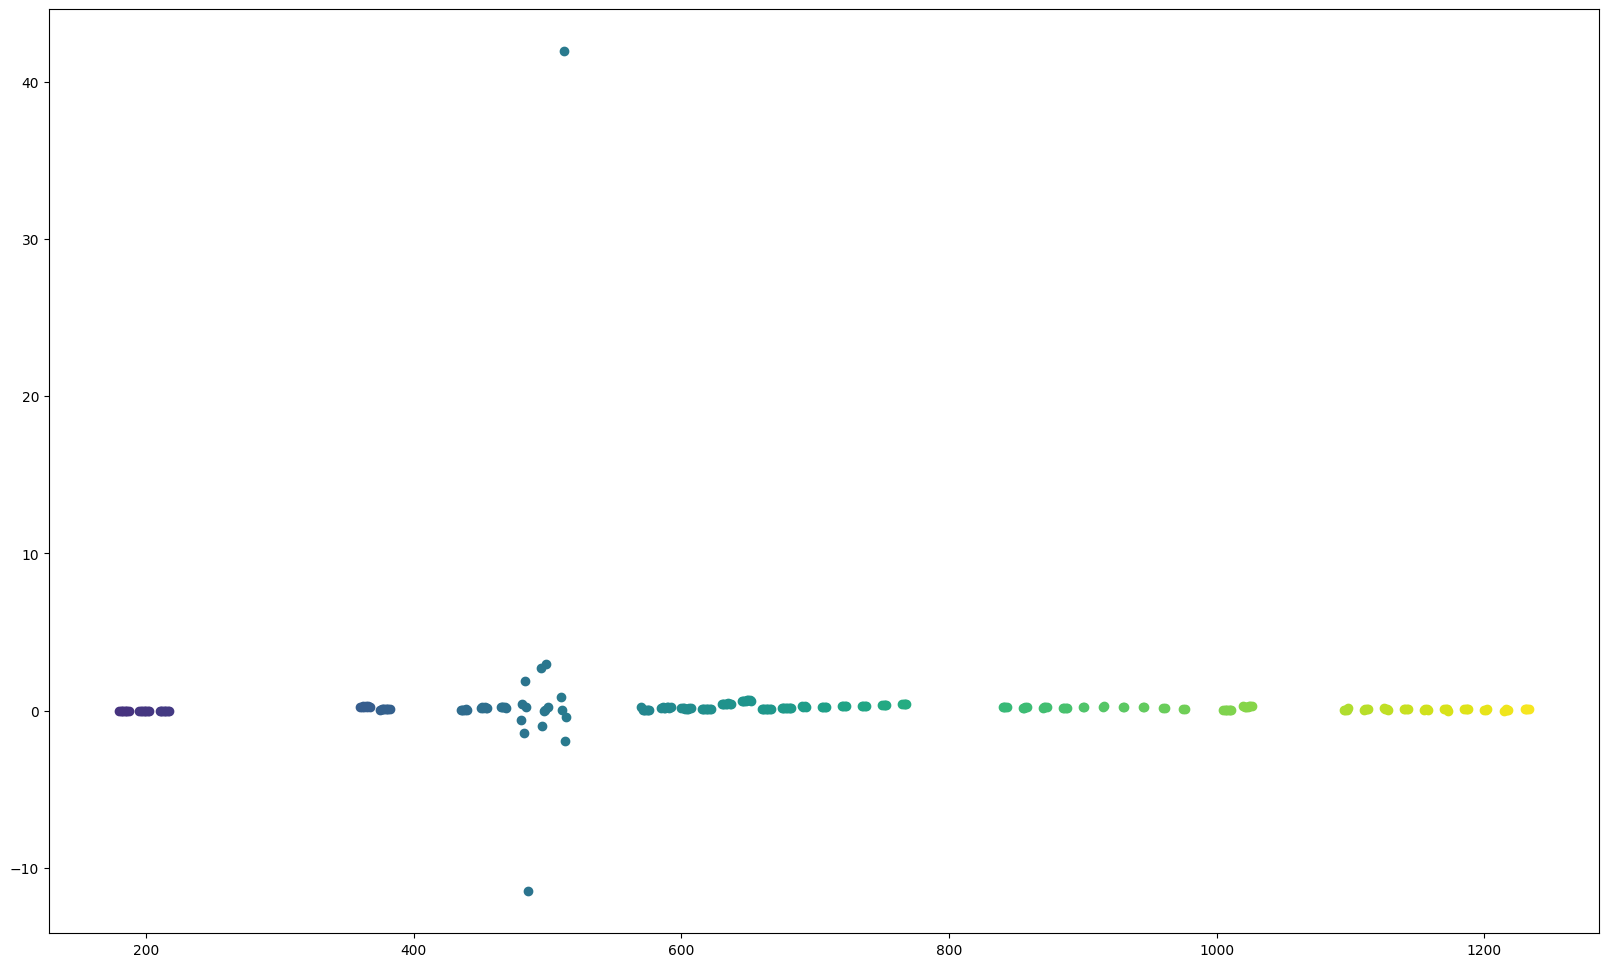

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'Batch No.', 'Sample #' and 'Mean Transmittance'
# Example DataFrame creation for demonstration
# df = pd.DataFrame({
#     'Batch No.': [1, 1, 2, 2, 3, 3, 4, 4],
#     'Sample #': [1, 2, 1, 2, 1, 2, 1, 2],
#     'Mean Transmittance': [0.1, 0.2, 0.3, 0.4, np.nan, 0.6, 0.7, 0.8]
# })

# Filter out rows where 'Mean Transmittance' is empty
df_filtered = df.dropna(subset=["Mean Transmittance"])

# Ensure 'Mean Transmittance' is numeric
df_filtered["Mean Transmittance"] = pd.to_numeric(df_filtered["Mean Transmittance"])

# Get unique batch numbers
batch_numbers = df_filtered["Batch No."].unique()

# Create a color map
colors = plt.cm.get_cmap(None, len(batch_numbers))

# Plot each batch with its specific color
plt.figure(figsize=(20, 12))
x_ticks = []
x_labels = []
spacing = 15  # Define a spacing factor for even distribution

for i, batch in enumerate(batch_numbers):
    batch_data = df_filtered[df_filtered["Batch No."] == batch].sort_values(
        by="Sample #"
    )
    x_positions = np.arange(len(batch_data)) + i * spacing
    plt.scatter(
        x_positions,
        batch_data["Mean Transmittance"],
        color=colors(i),
        label=f"Batch {batch}",
    )
    x_ticks.append(x_positions[len(x_positions) // 2])
    x_labels.append(f"{batch}")

# Set y-axis increments to a larger fixed amount
y_max = df_filtered["Mean Transmittance"].max()
y_min = df_filtered["Mean Transmittance"].min()
# plt.yticks(np.arange(y_min, y_max + 0.1, 0.05))
plt.yticks(np.arange(-0.1, 0.8, 0.05), fontsize=14)
# Set y-axis max and min
plt.ylim(-0.1, 0.7)
# plt.ylim(y_min, y_max)
# Set x-axis labels
plt.xticks(x_ticks, x_labels, rotation=0, fontsize=14)

plt.xlabel("Batch Number", fontsize=26)
plt.ylabel("Mean Transmittance", fontsize=26)
plt.title("Mean Transmittance vs Batch Number", fontsize=50)
plt.grid(True)
plt.show()

<ipython-input-20-513021734ef7>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(batch_numbers))


IndexError: index 0 is out of bounds for axis 0 with size 0

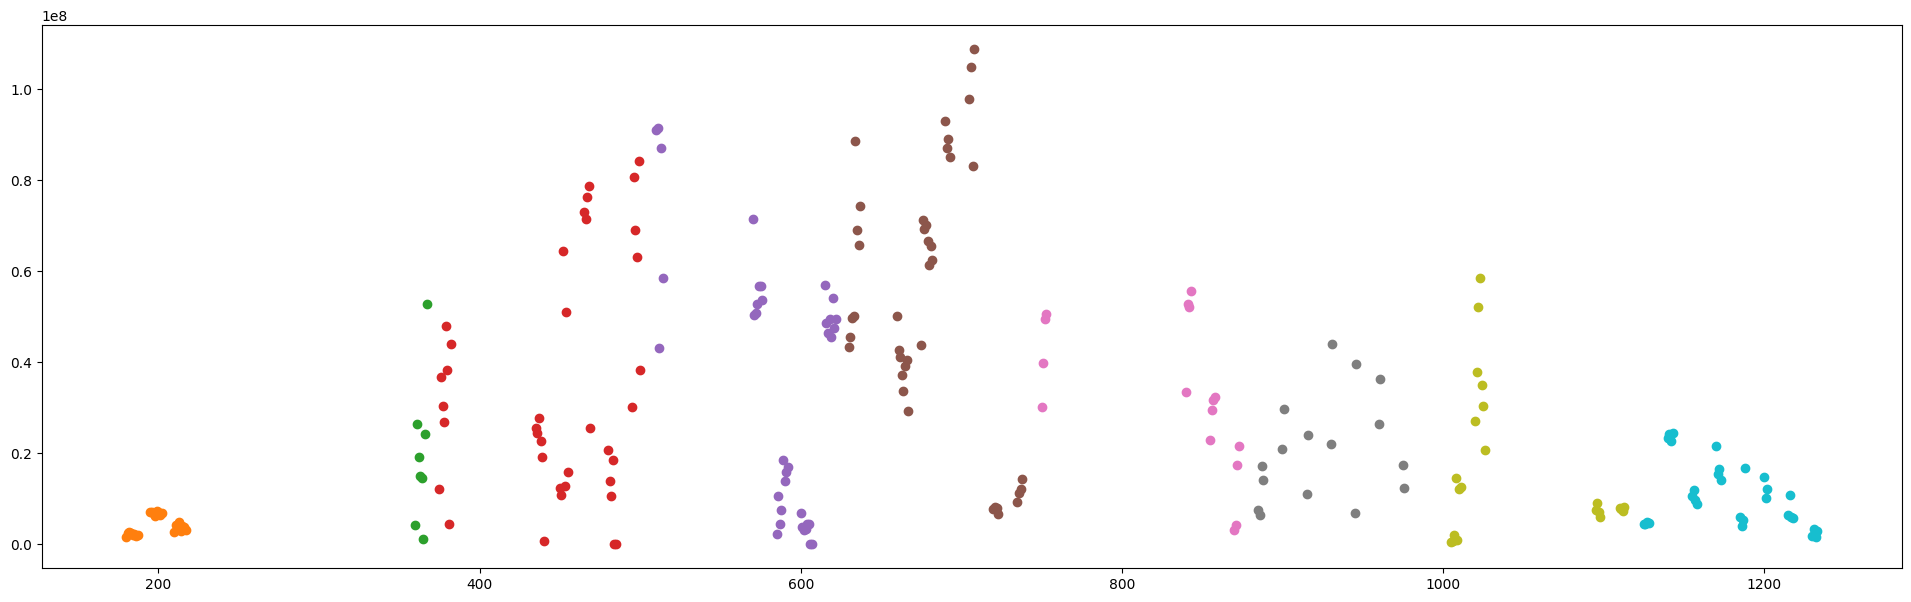

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# Filter out rows where any of the important columns are empty
df_filtered = df.dropna(
    subset=["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
)

# Ensure the columns are numeric
columns_to_numeric = [
    "PL Peak Intensity Mean",
    "PL Peak Center Mean",
    "PL Peak FWHM Mean",
]
df_filtered[columns_to_numeric] = df_filtered[columns_to_numeric].apply(pd.to_numeric)

# Get unique batch numbers
batch_numbers = df_filtered["Batch No."].unique()

# Create a color map
colors = plt.cm.get_cmap("tab10", len(batch_numbers))

# Plot each batch with its specific color
plt.figure(figsize=(24, 24))  # Adjust figure size to fit 3x1 grid
spacing = 15  # Define a spacing factor for even distribution

# Define the columns to plot and their labels
columns_to_plot = ["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
y_labels = ["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
titles = [
    "PL Peak Intensity Mean vs Batch Number",
    "PL Peak Center Mean vs Batch Number",
    "PL Peak FWHM Mean vs Batch Number",
]

# Batches to ignore
ignore_batches = [52, 44]

# Calculate y-axis limits based on the data excluding ignored batches
y_limits = {}
for column in columns_to_plot:
    valid_data = df_filtered[~df_filtered["Batch No."].isin(ignore_batches)][column]
    y_limits[column] = (valid_data.min(), valid_data.max())

for j, column in enumerate(columns_to_plot):
    plt.subplot(3, 1, j + 1)  # Create a subplot for each column in a 3x1 grid
    x_ticks = []
    x_labels = []
    for i, batch in enumerate(batch_numbers):
        batch_data = df_filtered[df_filtered["Batch No."] == batch].sort_values(
            by="Sample #"
        )
        x_positions = np.arange(len(batch_data)) + i * spacing
        if (
            batch not in ignore_batches and not batch_data.empty
        ):  # Only plot if there's data for this batch and it's not ignored
            plt.scatter(
                x_positions, batch_data[column], color=colors(i), label=f"Batch {batch}"
            )
        x_ticks.append(x_positions[len(x_positions) // 2])
        x_labels.append(f"{batch}")

    # Set y-axis limits and ticks based on the pre-calculated limits
    y_min, y_max = y_limits[column]

    plt.gca().yaxis.set_major_locator(
        MaxNLocator(nbins=10, prune="both")
    )  # Set a maximum of 10 ticks

    plt.ylim(y_min, y_max)

    # Set x-axis labels
    plt.xticks(x_ticks, x_labels, rotation=0, fontsize=14)

    plt.xlabel("Batch Number", fontsize=26)
    plt.ylabel(y_labels[j], fontsize=26)
    plt.title(titles[j], fontsize=26)
    plt.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-21-7a2a4f8dac71>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(batch_numbers))


IndexError: index 0 is out of bounds for axis 0 with size 0

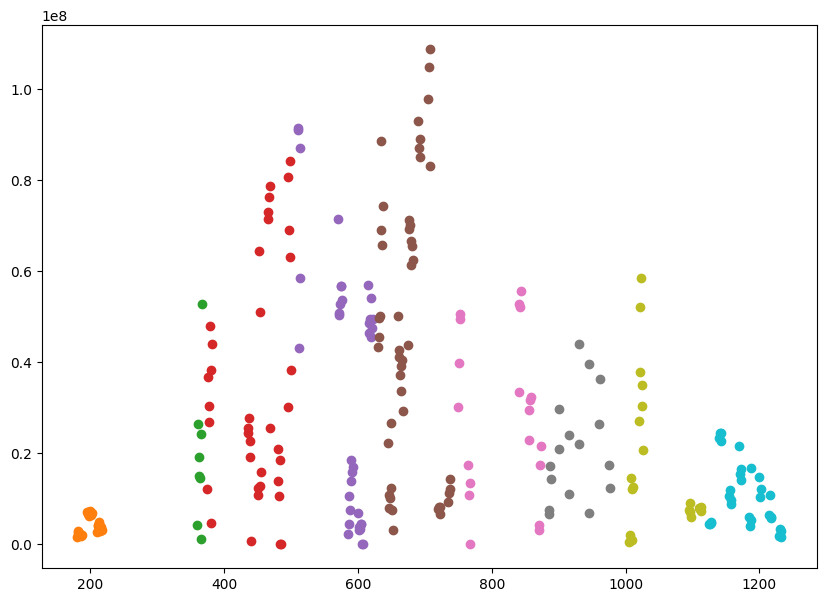

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Example DataFrame creation for demonstration
# df = pd.DataFrame({
#     'Batch No.': [1, 1, 2, 2, 3, 3, 4, 4],
#     'Sample #': [1, 2, 1, 2, 1, 2, 1, 2],
#     'PL Peak Intensity Mean': [2196242.331, 2196243.331, 2196244.331, 2196245.331, 2196246.331, 2196247.331, 2196248.331, 2196249.331],
#     'PL Peak Center Mean': [1.5424, 1.5425, 1.5426, 1.5427, 1.5428, 1.5429, 1.5430, 1.5431],
#     'PL Peak FWHM Mean': [0.08093486941, 0.08093486942, 0.08093486943, 0.08093486944, 0.08093486945, 0.08093486946, 0.08093486947, 0.08093486948]
# })

# Filter out rows where any of the important columns are empty
df_filtered = df.dropna(
    subset=["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
)

# Ensure the columns are numeric
columns_to_numeric = [
    "PL Peak Intensity Mean",
    "PL Peak Center Mean",
    "PL Peak FWHM Mean",
]
df_filtered[columns_to_numeric] = df_filtered[columns_to_numeric].apply(pd.to_numeric)

# Get unique batch numbers
batch_numbers = df_filtered["Batch No."].unique()

# Create a color map
colors = plt.cm.get_cmap("tab10", len(batch_numbers))

# Plot each batch with its specific color
plt.figure(figsize=(10, 24))  # Adjust figure size to fit 3x1 grid
x_ticks = []
x_labels = []
spacing = 15  # Define a spacing factor for even distribution

# Define the columns to plot and their labels
columns_to_plot = ["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
y_labels = ["PL Peak Intensity Mean", "PL Peak Center Mean", "PL Peak FWHM Mean"]
titles = [
    "PL Peak Intensity Mean vs Batch Number",
    "PL Peak Center Mean vs Batch Number",
    "PL Peak FWHM Mean vs Batch Number",
]

for j, column in enumerate(columns_to_plot):
    plt.subplot(3, 1, j + 1)  # Create a subplot for each column in a 3x1 grid
    for i, batch in enumerate(batch_numbers):
        batch_data = df_filtered[df_filtered["Batch No."] == batch].sort_values(
            by="Sample #"
        )
        x_positions = np.arange(len(batch_data)) + i * spacing
        plt.scatter(
            x_positions, batch_data[column], color=colors(i), label=f"Batch {batch}"
        )
        if j == 0:  # Only set x_ticks and x_labels once
            x_ticks.append(x_positions[len(x_positions) // 2])
            x_labels.append(f"{batch}")

    # Set y-axis limits and ticks based on the range of the data
    y_max = df_filtered[column].max()
    y_min = df_filtered[column].min()

    plt.gca().yaxis.set_major_locator(
        MaxNLocator(nbins=10, prune="both")
    )  # Set a maximum of 10 ticks

    plt.ylim(y_min, y_max)

    # Set x-axis labels
    plt.xticks(x_ticks, x_labels, rotation=0, fontsize=14)

    plt.xlabel("Batch Number", fontsize=26)
    plt.ylabel(y_labels[j], fontsize=26)
    plt.title(titles[j], fontsize=26)
    plt.grid(True)

plt.tight_layout()
plt.show()

**Calculating Area Under and Above UV Curve**

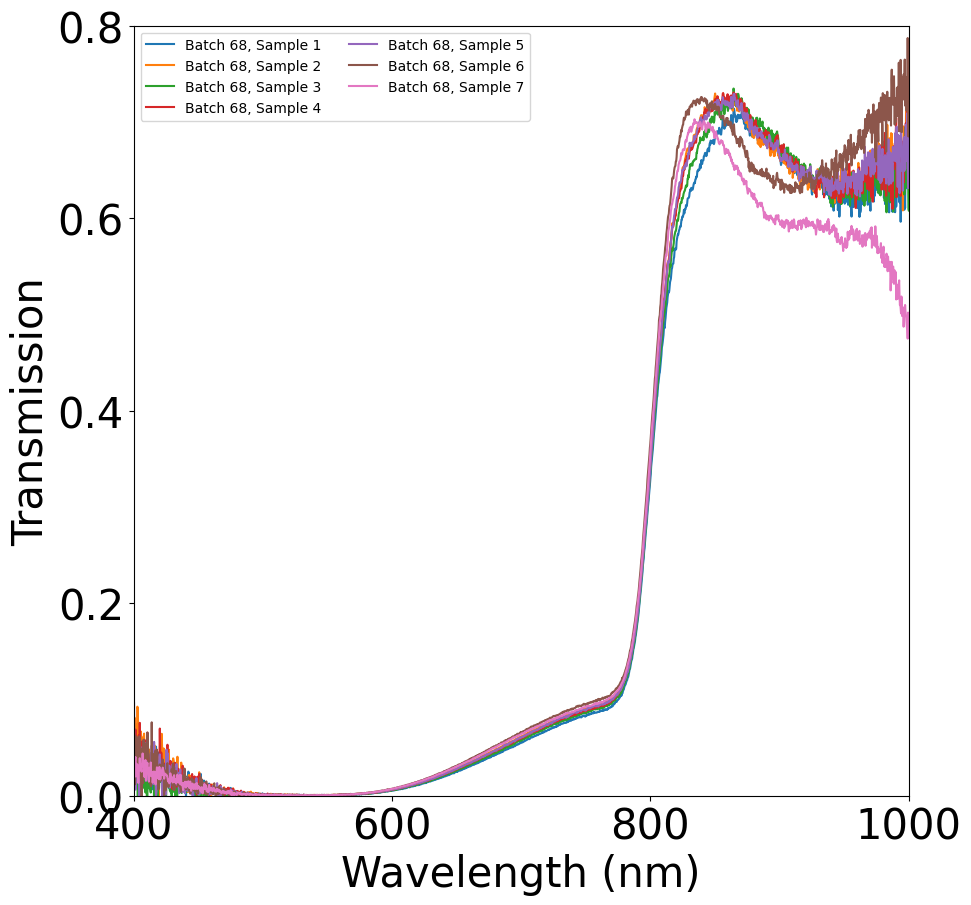

In [ ]:
# Plotting Individual UV plots

label_size = 30

plt.figure(figsize=(10, 10))

for b in range(68, 69):  # 74,84,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {6}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            plt.plot(
                wl_wave_axis, sample_spectrum_final, label=f"Batch {b}, Sample {s}"
            )
            # plt.title(f'0-1 Transmission Spectrum')
            plt.xlim(400, 1000)
            plt.xticks([400, 600, 800, 1000])
            plt.ylim(0, 0.8)  # 1
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
            plt.xlabel("Wavelength (nm)", fontsize=label_size)
            plt.ylabel("Transmission", fontsize=label_size)
            plt.legend(loc="upper left", ncol=2)  # fontsize=5
            plt.tick_params(axis="both", which="major", labelsize=label_size)


plt.show()

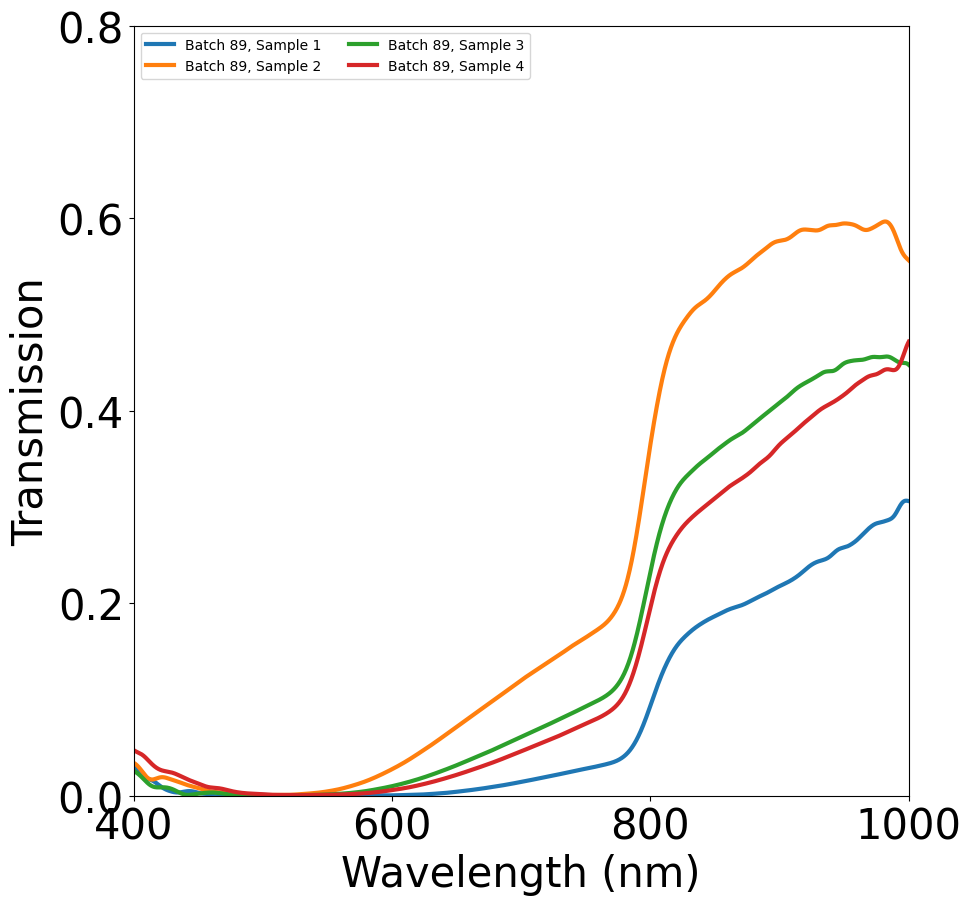

In [ ]:
label_size = 30

sigma = 15  # Adjust sigma for different levels of smoothing

plt.figure(figsize=(10, 10))

for b in range(89, 90):  # 74,84,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {6}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            # Apply Gaussian smoothing
            smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

            # Plot the smoothed curve

            # plt.plot(wl_wave_axis, sample_spectrum_final, linewidth = 3, label=f'Batch {b}, Sample {s}')
            plt.plot(
                wl_wave_axis,
                smoothed_spectrum,
                linewidth=3,
                label=f"Batch {b}, Sample {s}",
            )

            # plt.title(f'0-1 Transmission Spectrum')
            plt.xlim(400, 1000)
            plt.xticks([400, 600, 800, 1000])
            plt.ylim(0, 0.8)  # 1
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
            plt.xlabel("Wavelength (nm)", fontsize=label_size)
            plt.ylabel("Transmission", fontsize=label_size)
            plt.legend(loc="upper left", ncol=2)  # fontsize=5
            plt.tick_params(axis="both", which="major", labelsize=label_size)

# plt.axvline(x=830, color='r', linestyle='--', linewidth=2, label='800 nm')
# plt.show()

plt.show()

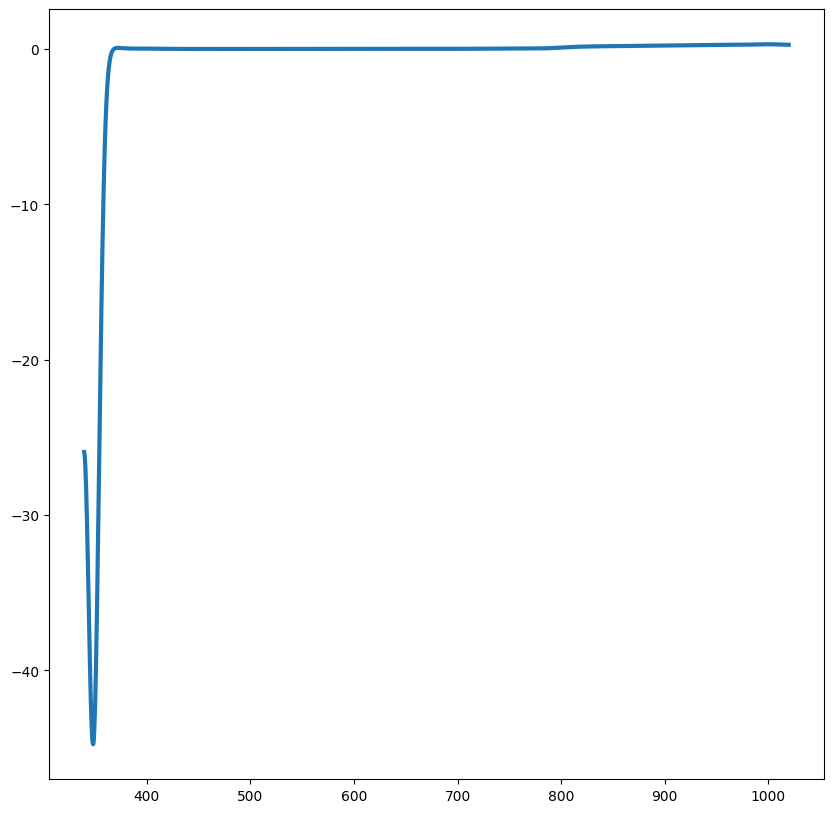

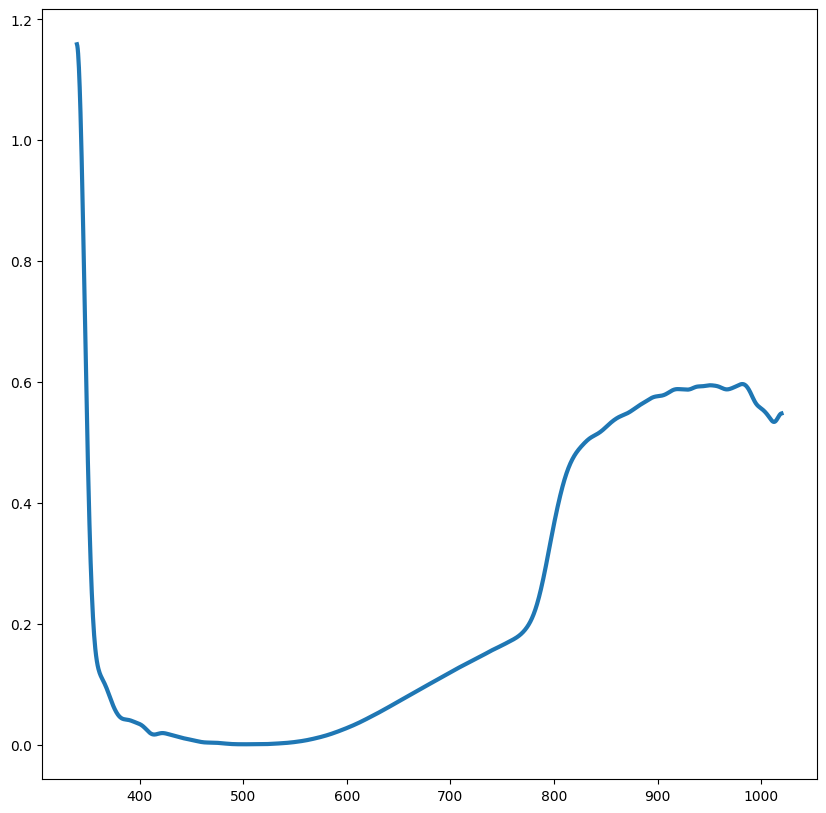

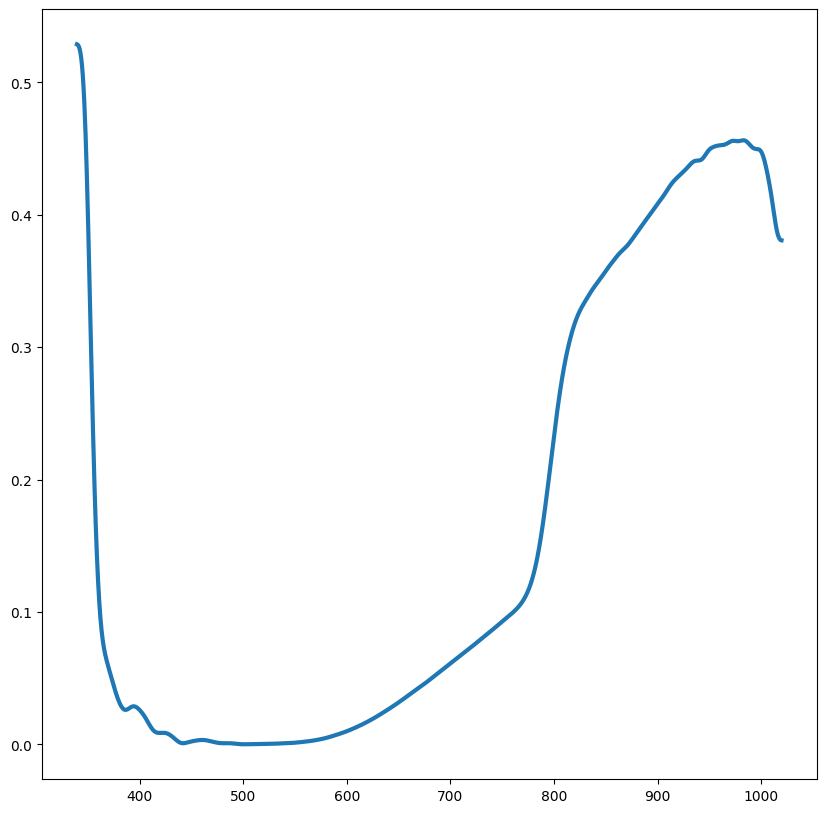

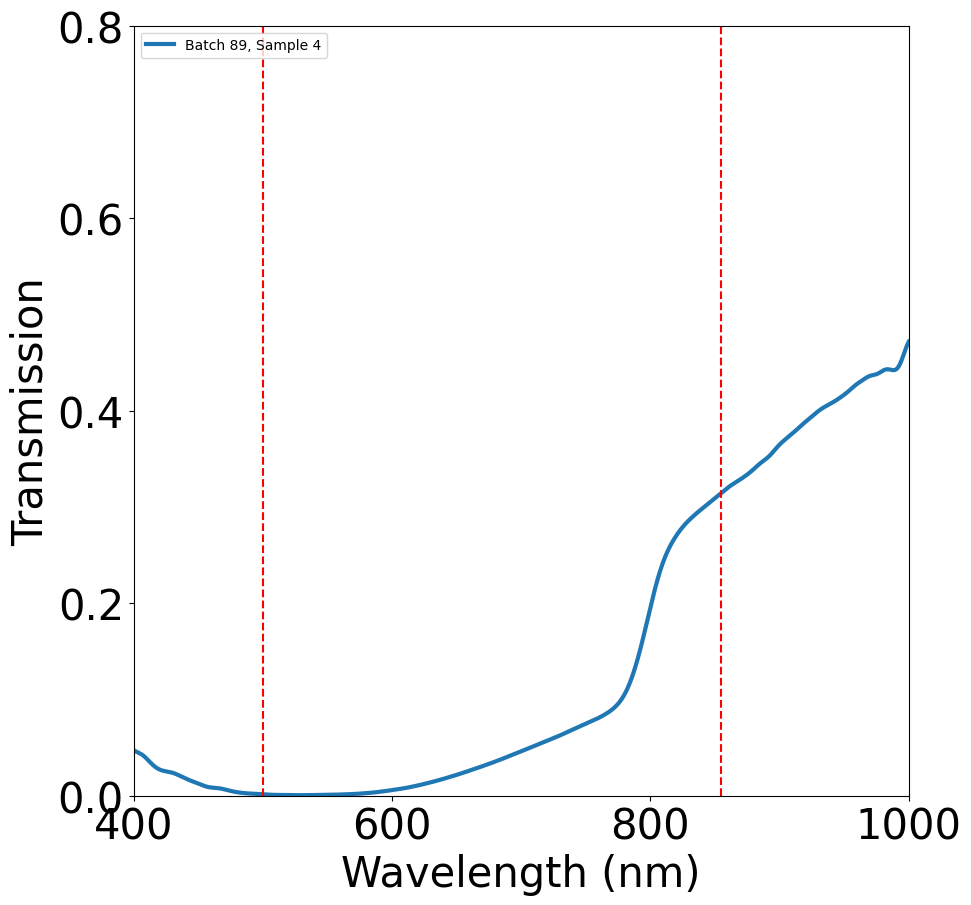

In [ ]:
label_size = 30

sigma = 15  # Adjust sigma for different levels of smoothing


for b in range(89, 90):  # 74,84,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {6}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")

        plt.figure(figsize=(10, 10))

        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            # Apply Gaussian smoothing
            smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

            # Plot the smoothed curve

            # plt.plot(wl_wave_axis, sample_spectrum_final, linewidth = 3, label=f'Batch {b}, Sample {s}')
            plt.plot(
                wl_wave_axis,
                smoothed_spectrum,
                linewidth=3,
                label=f"Batch {b}, Sample {s}",
            )


# plt.title(f'0-1 Transmission Spectrum')
plt.xlim(400, 1000)
plt.xticks([400, 600, 800, 1000])
plt.ylim(0, 0.8)  # 1
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("Transmission", fontsize=label_size)
plt.legend(loc="upper left", ncol=2)  # fontsize=5
plt.tick_params(axis="both", which="major", labelsize=label_size)

plt.axvline(500, color="r", linestyle="--")
plt.axvline(855, color="r", linestyle="--")
plt.show()

Batch 93, Sample 2:


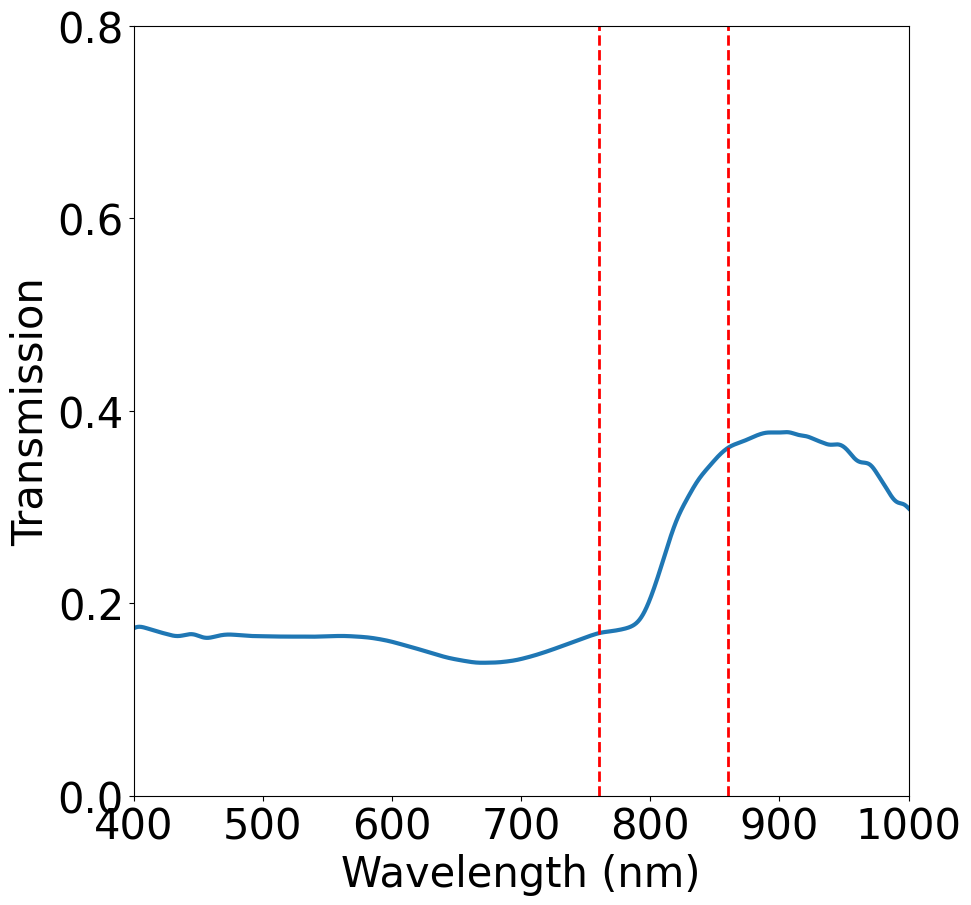

In [ ]:
sigma = 15  # Adjust sigma for different levels of smoothing

# Batch Number
b = 93

batch = df[df["Batch No."] == b]


# Sample Number
s = 2

sample = batch[batch["Sample #"] == str(s)]

print(f"Batch {b}, Sample {s}:")

file_path = get_spec_run_filepath(sample)


with h5py.File(file_path, "r") as hf:
    photo = hf["measurement/spec_run/photo"][:]
    wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
    wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
    wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
    wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
    wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
    wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
    wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
    settings_gr = hf["app/settings"]
    sample_id = settings_gr.attrs["sample"]


# print("File data has been read successfully.")
sample_spectrum_corr = (
    wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
    - wl_dark_spectrum / wl_dark_int_time
)
sample_spectrum_corr_mean = np.mean(
    sample_spectrum_corr, axis=0
)  # Average individual spectra per sample
sample_spectrum_final = sample_spectrum_corr_mean / (
    wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
)  # Divide by the reference


# Apply Gaussian smoothing
smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

label_size = 30

plt.figure(figsize=(10, 10))
plt.plot(wl_wave_axis, smoothed_spectrum, linewidth=3, label=f"Batch {b}, Sample {s}")
plt.xlim(400, 1000)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("Transmission", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)

# plt.legend(fontsize=5, loc='upper left')
plt.axvline(x=760, color="r", linestyle="--", linewidth=2, label="800 nm")
plt.axvline(x=860, color="r", linestyle="--", linewidth=2, label="800 nm")

plt.show()

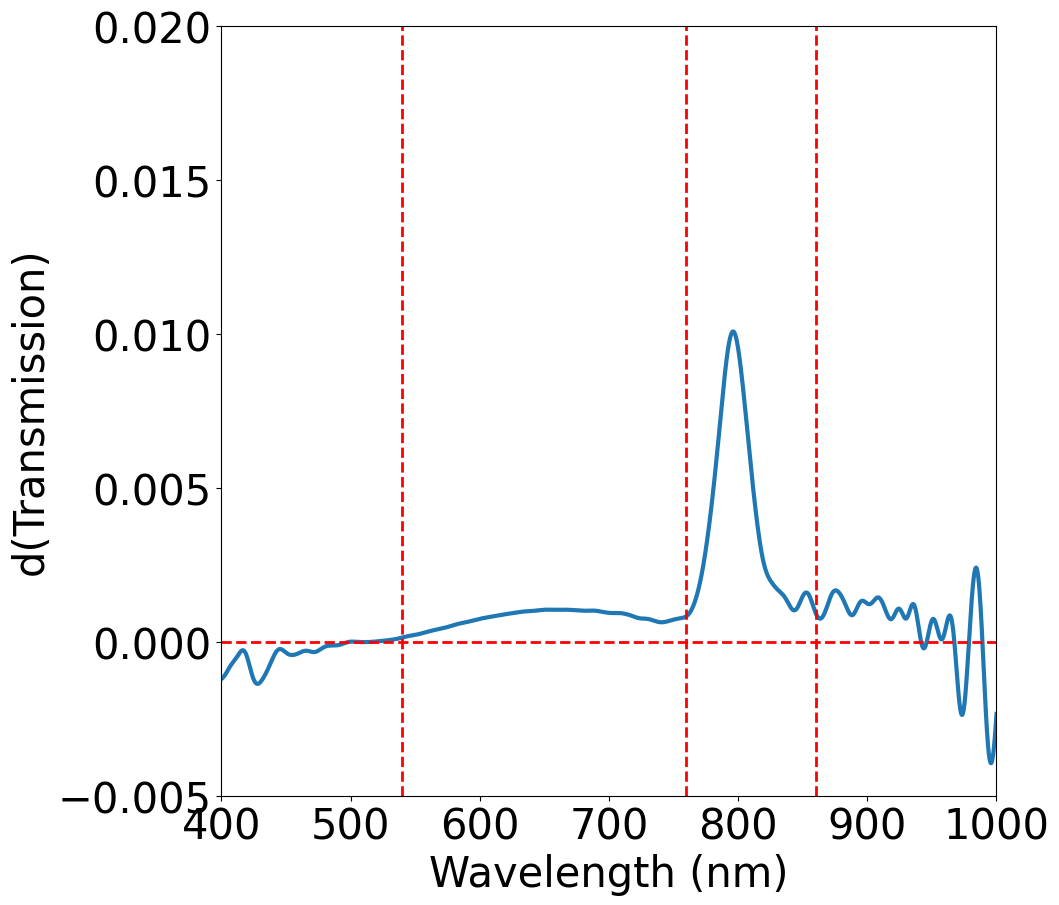

In [ ]:
label_size = 30

# First derivative (gradient)
d_smoothed_spectrum = np.gradient(smoothed_spectrum, wl_wave_axis)


plt.figure(figsize=(10, 10))

plt.plot(wl_wave_axis, d_smoothed_spectrum, linewidth=3, label=f"Batch {b}, Sample {s}")
# plt.title(f'0-1 Transmission Spectrum')
plt.xlim(400, 1000)
plt.ylim(-0.005, 0.02)

plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("d(Transmission)", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
plt.axvline(x=540, color="r", linestyle="--", linewidth=2, label="800 nm")
plt.axvline(x=760, color="r", linestyle="--", linewidth=2, label="800 nm")
plt.axvline(x=860, color="r", linestyle="--", linewidth=2, label="800 nm")
# plt.legend(fontsize=5, loc='upper left')
plt.axhline(y=0, color="r", linestyle="--", linewidth=2, label="800 nm")

plt.show()

Area under the curve from 500 nm to 865 nm: 63.48917786998532
Area above the curve from 500 nm to 865 nm: 62.5806716041786


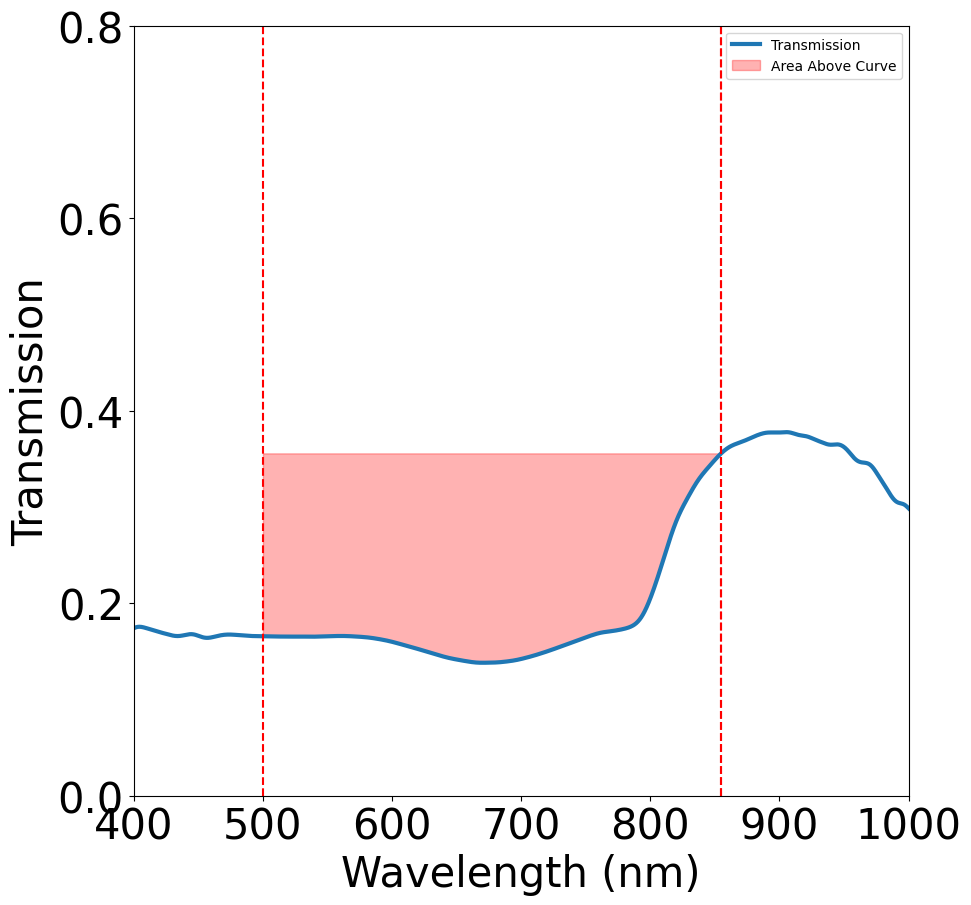

In [ ]:
# Calcauting Area for one sample!

# Limit data between 500 and 865 nm
mask = (wl_wave_axis >= 500) & (wl_wave_axis <= 855)  # 855
x_selected = wl_wave_axis[mask]
y_selected = smoothed_spectrum[mask]

# Maximum transmission level (e.g., 1.0)
transmission_of_interest = y_selected[-1]

# Identifying the wavelength where the max_transmission occurs first, then taking the area from that wavelength
indices = np.where(y_selected >= transmission_of_interest)[0]

# Select the first occurrence
first_index = indices[0]

# Area under the curve
area_under_curve = np.trapz(y_selected[0:first_index], x_selected[0:first_index])

# Area above the curve
area_above_curve = (
    np.trapz(
        [transmission_of_interest] * len(x_selected[0:first_index]),
        x_selected[0:first_index],
    )
    - area_under_curve
)

print(f"Area under the curve from 500 nm to 865 nm: {area_under_curve}")
print(f"Area above the curve from 500 nm to 865 nm: {area_above_curve}")


label_size = 30

# Optionally, plot the curve with the selected region
plt.figure(figsize=(10, 10))
plt.plot(wl_wave_axis, smoothed_spectrum, linewidth=3, label="Transmission")
plt.fill_between(
    x_selected[0:first_index],
    y_selected[0:first_index],
    transmission_of_interest,
    color="red",
    alpha=0.3,
    label="Area Above Curve",
)
plt.xlim(400, 1000)
plt.ylim(0, 0.8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.axvline(500, color="r", linestyle="--")
plt.axvline(855, color="r", linestyle="--")
plt.axvline(x_selected[first_index], color="r", linestyle="--")

plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("Transmission", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
plt.legend()
plt.show()

Area under the curve from 500 nm to 865 nm: 52.207490871271105
Area above the curve from 500 nm to 865 nm: 146.1406350107269


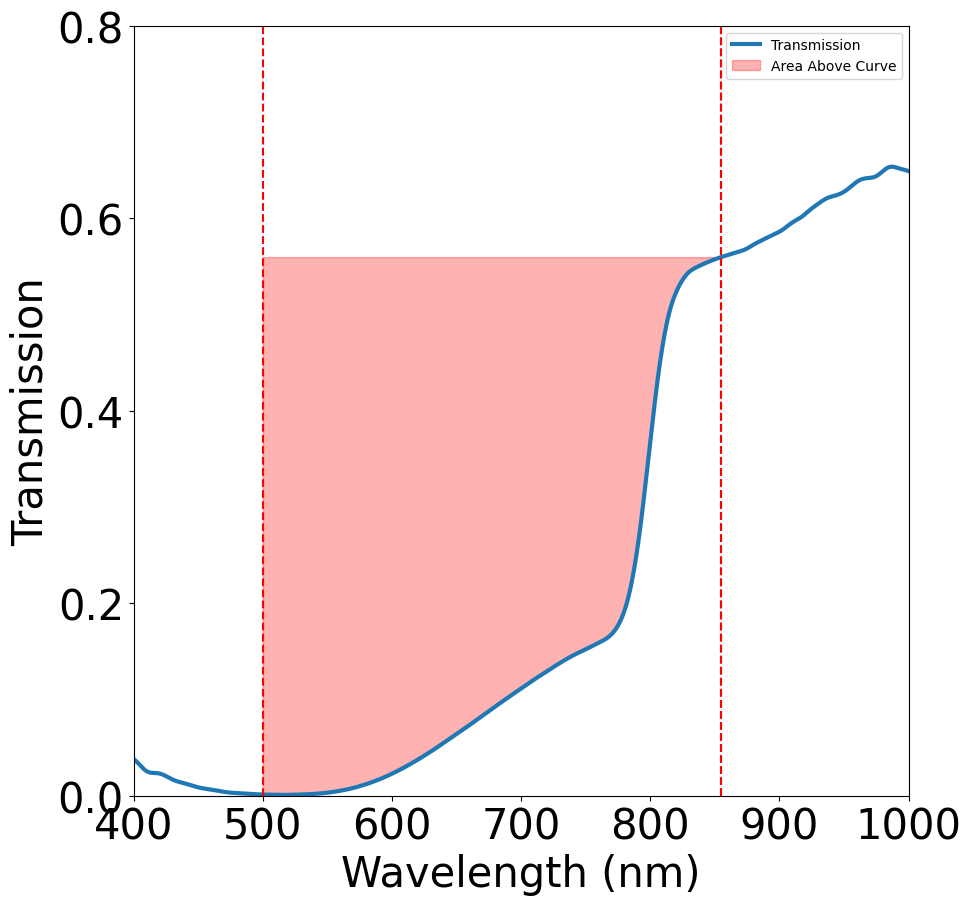

Area under the curve from 500 nm to 865 nm: 58.712755023410004
Area above the curve from 500 nm to 865 nm: 147.7780676192374


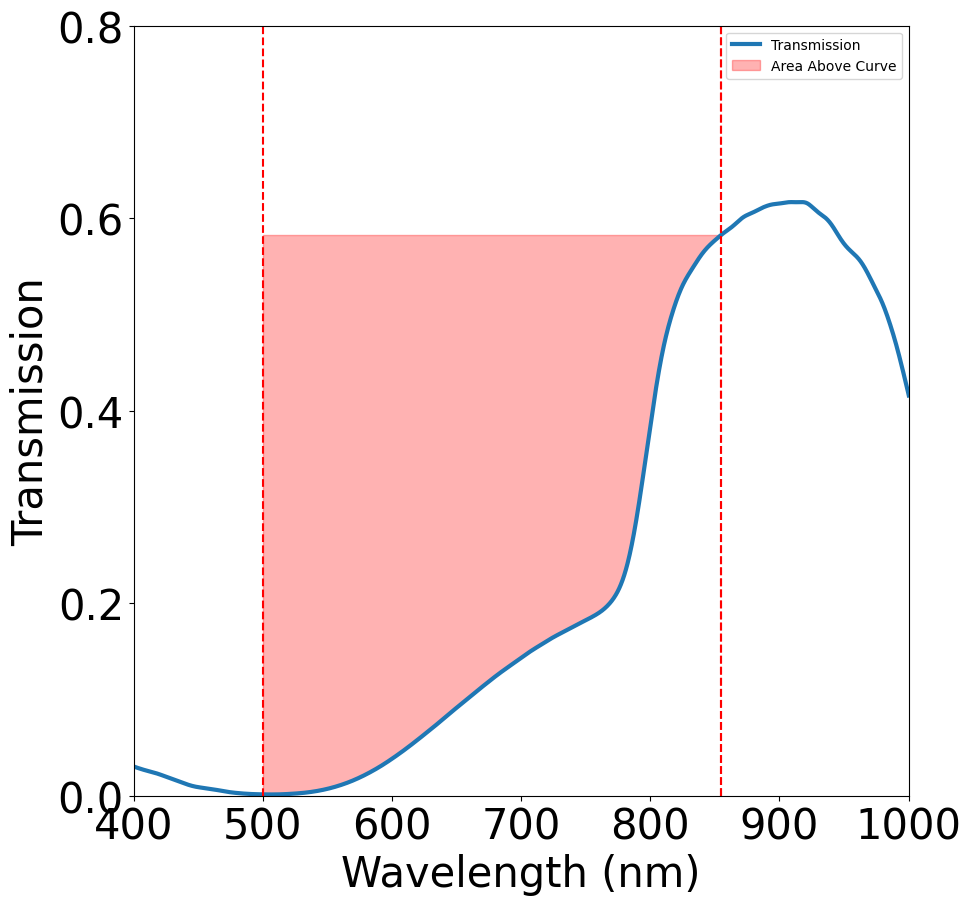

Area under the curve from 500 nm to 865 nm: 57.37626033193028
Area above the curve from 500 nm to 865 nm: 143.59294200248166


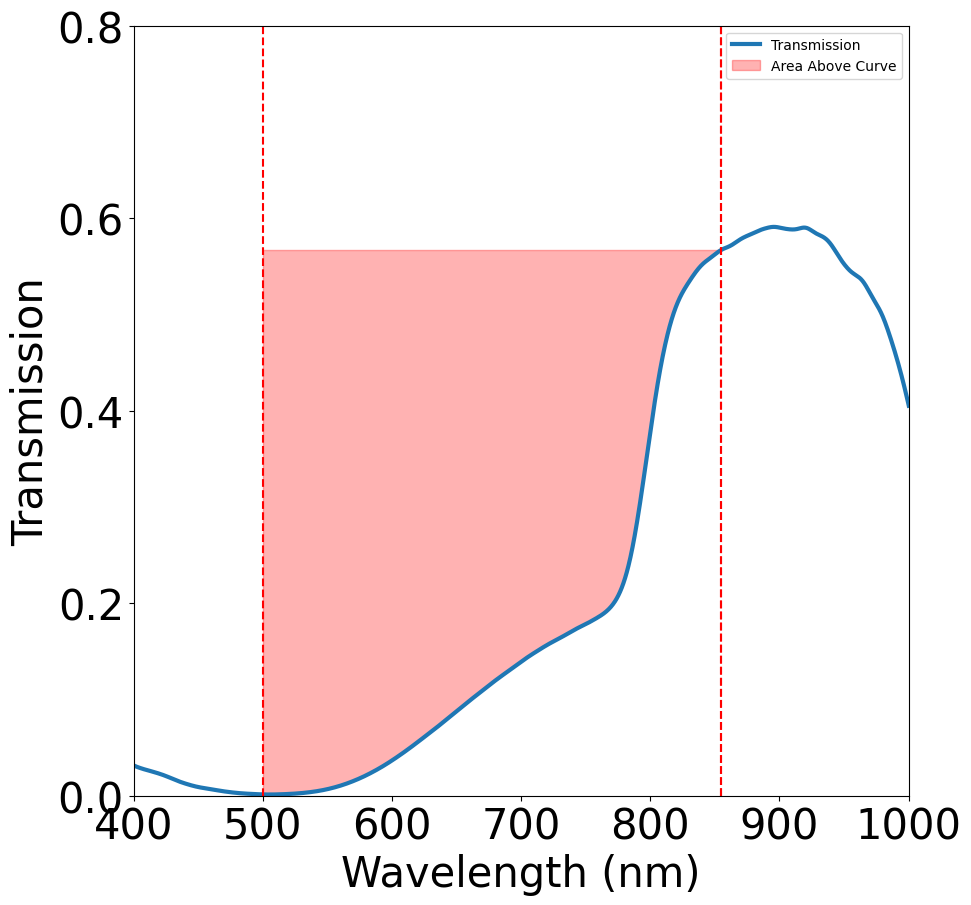

Area under the curve from 500 nm to 865 nm: 56.13847019742589
Area above the curve from 500 nm to 865 nm: 144.00682915682705


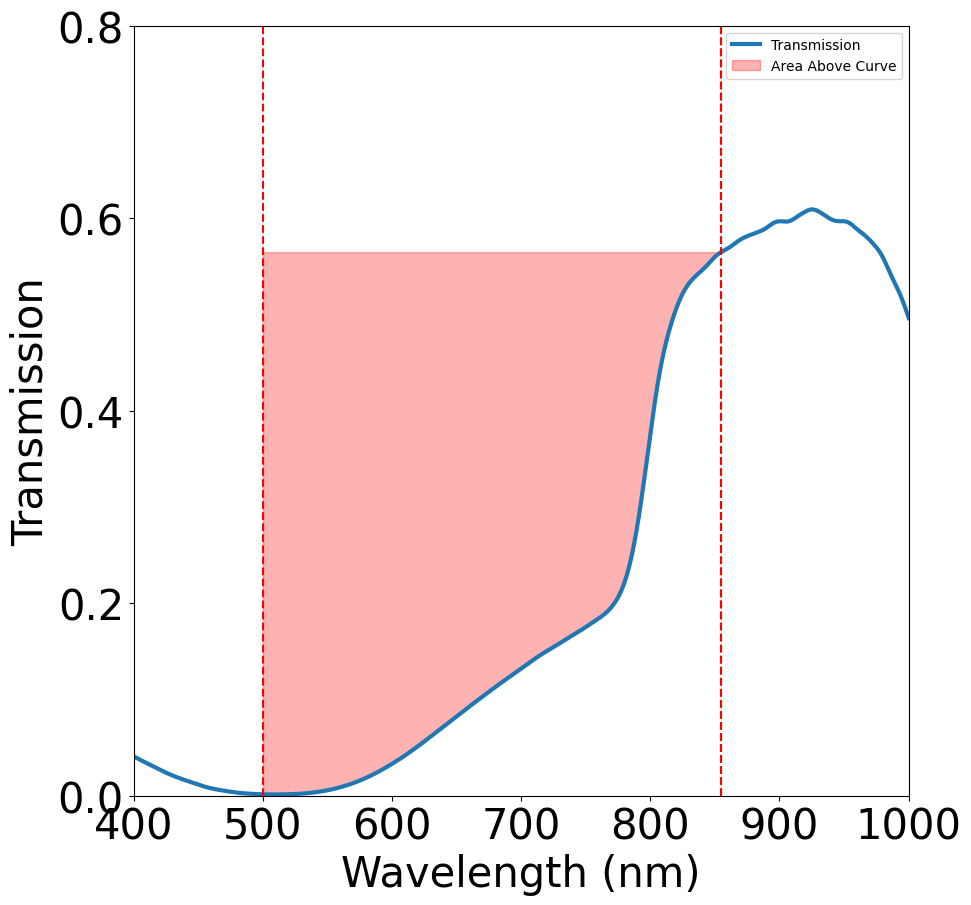

In [ ]:
# Calculating Area for many samples

label_size = 30

sigma = 15  # Adjust sigma for different levels of smoothing


for b in range(80, 81):  # 74,84,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {6}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            # Apply Gaussian smoothing
            smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

            # Limit data between 500 and 865 nm
            mask = (wl_wave_axis >= 500) & (wl_wave_axis <= 855)
            x_selected = wl_wave_axis[mask]
            y_selected = smoothed_spectrum[mask]

            # Maximum transmission level (e.g., 1.0)
            transmission_of_interest = y_selected[-1]

            # Identifying the wavelength where the max_transmission occurs first, then taking the area from that wavelength
            indices = np.where(y_selected >= transmission_of_interest)[0]

            # Select the first occurrence
            first_index = indices[0]

            # Area under the curve
            area_under_curve = np.trapz(
                y_selected[0:first_index], x_selected[0:first_index]
            )

            # Area above the curve
            area_above_curve = (
                np.trapz(
                    [transmission_of_interest] * len(x_selected[0:first_index]),
                    x_selected[0:first_index],
                )
                - area_under_curve
            )

            print(f"Area under the curve from 500 nm to 865 nm: {area_under_curve}")
            print(f"Area above the curve from 500 nm to 865 nm: {area_above_curve}")

            label_size = 30

            # Optionally, plot the curve with the selected region
            plt.figure(figsize=(10, 10))
            plt.plot(wl_wave_axis, smoothed_spectrum, linewidth=3, label="Transmission")
            plt.fill_between(
                x_selected[0:first_index],
                y_selected[0:first_index],
                transmission_of_interest,
                color="red",
                alpha=0.3,
                label="Area Above Curve",
            )
            plt.xlim(400, 1000)
            plt.ylim(0, 0.8)
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
            plt.axvline(500, color="r", linestyle="--")
            plt.axvline(855, color="r", linestyle="--")
            plt.axvline(x_selected[first_index], color="r", linestyle="--")

            plt.xlabel("Wavelength (nm)", fontsize=label_size)
            plt.ylabel("Transmission", fontsize=label_size)
            plt.tick_params(axis="both", which="major", labelsize=label_size)
            plt.legend()
            plt.show()

**Absorbance Calculation**

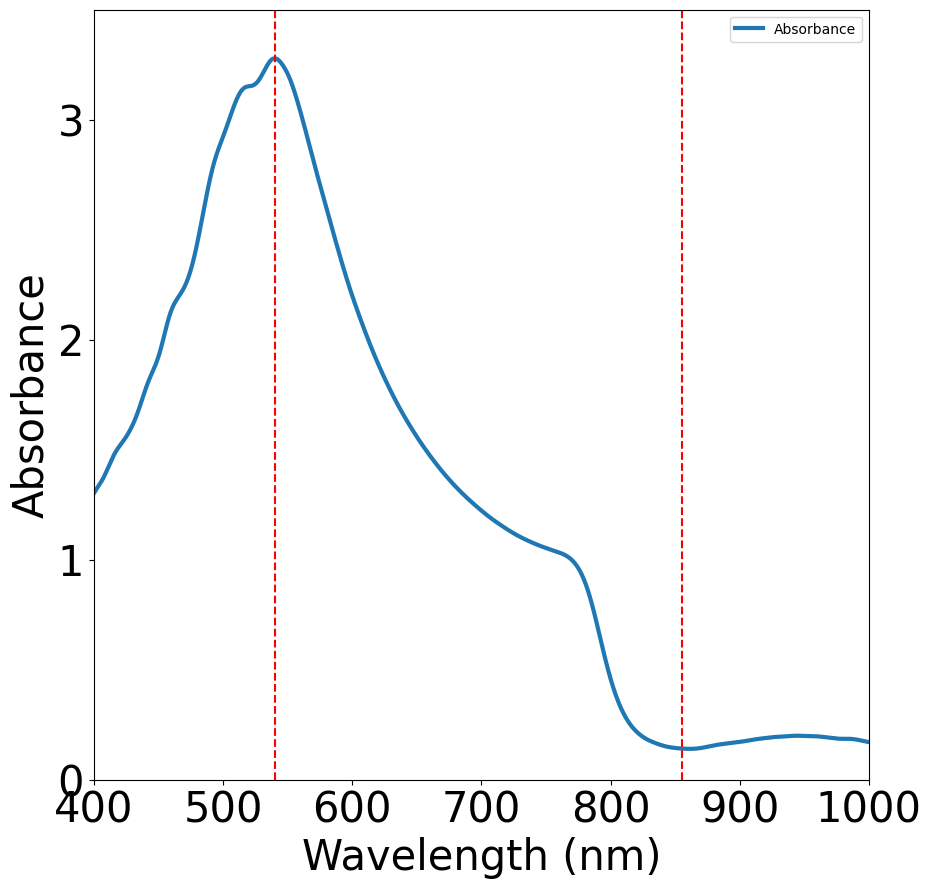

In [ ]:
# Calculating Absorbance

smooth_absorbance = -np.log10(smoothed_spectrum)


label_size = 30

# Optionally, plot the curve with the selected region
plt.figure(figsize=(10, 10))
plt.plot(wl_wave_axis, smooth_absorbance, linewidth=3, label="Absorbance")
plt.xlim(400, 1000)
plt.ylim(0, 3.5)
plt.yticks([0, 1, 2, 3])
plt.axvline(540, color="r", linestyle="--")
plt.axvline(855, color="r", linestyle="--")
plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("Absorbance", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
plt.legend()
plt.show()

<ipython-input-33-3a3335c56eec>:39: RuntimeWarning: invalid value encountered in log10
  smooth_absorbance = -np.log10(smoothed_spectrum)


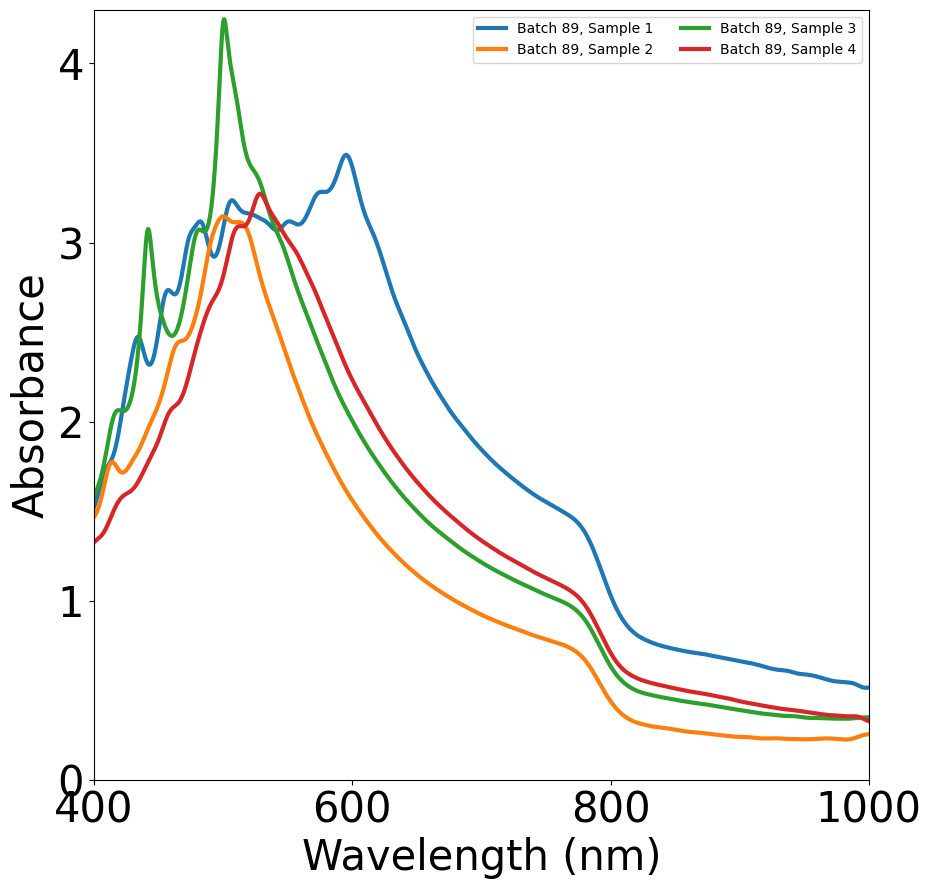

In [ ]:
label_size = 30

plt.figure(figsize=(10, 10))

for b in range(89, 90):  # 74,84,1):
    batch = df[df["Batch No."] == b]
    # display(batch)
    num_samples = len(batch)
    for s in range(1, num_samples + 1):
        # for s in {6}:
        sample = batch[batch["Sample #"] == str(s)]
        # print(f"Batch {b}, Sample {s}:")
        file_path = get_spec_run_filepath(sample)
        if not file_path:
            continue
        with h5py.File(file_path, "r") as hf:
            photo = hf["measurement/spec_run/photo"][:]
            wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
            wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
            wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
            wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
            wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
            wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
            wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
            settings_gr = hf["app/settings"]
            sample_id = settings_gr.attrs["sample"]

            # print("File data has been read successfully.")
            sample_spectrum_corr = (
                wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
                - wl_dark_spectrum / wl_dark_int_time
            )
            sample_spectrum_corr_mean = np.mean(
                sample_spectrum_corr, axis=0
            )  # Average individual spectra per sample
            sample_spectrum_final = sample_spectrum_corr_mean / (
                wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
            )  # Divide by the reference

            # Apply Gaussian smoothing
            smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

            # Calculate Absorbance
            smooth_absorbance = -np.log10(smoothed_spectrum)

            plt.plot(
                wl_wave_axis,
                smooth_absorbance,
                linewidth=3,
                label=f"Batch {b}, Sample {s}",
            )
            # plt.title(f'0-1 Transmission Spectrum')
            plt.xlim(400, 1000)
            plt.xticks([400, 600, 800, 1000])
            plt.ylim(0, 4.3)  # 1
            plt.yticks([0, 1, 2, 3, 4])
            plt.xlabel("Wavelength (nm)", fontsize=label_size)
            plt.ylabel("Absorbance", fontsize=label_size)
            plt.legend(loc="upper right", ncol=2)  # fontsize=5
            plt.tick_params(axis="both", which="major", labelsize=label_size)


plt.show()

<ipython-input-37-ae7a199ca5e5>:47: RuntimeWarning: invalid value encountered in log10
  smooth_absorbance = -np.log10(smoothed_spectrum)


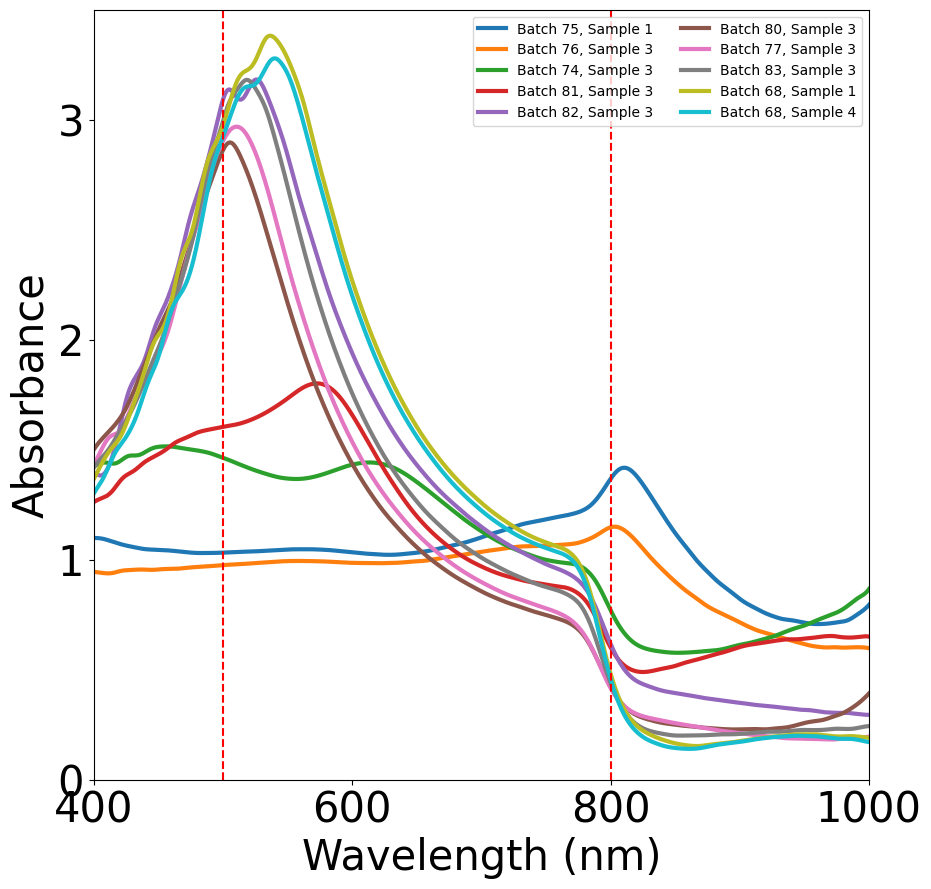

In [ ]:
label_size = 30

sigma = 15  # Adjust sigma for different levels of smoothing


my_batches = np.array([75, 76, 74, 81, 82, 80, 77, 83, 68, 68])
my_samples = np.array([1, 3, 3, 3, 3, 3, 3, 3, 1, 4])

plt.figure(figsize=(10, 10))

for i in range(len(my_batches)):
    b = my_batches[i]
    s = my_samples[i]

    batch = df[df["Batch No."] == b]
    sample = batch[batch["Sample #"] == str(s)]

    # print(f"Batch {b}, Sample {s}:")
    file_path = get_spec_run_filepath(sample)
    if not file_path:
        continue
    with h5py.File(file_path, "r") as hf:
        photo = hf["measurement/spec_run/photo"][:]
        wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
        wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
        wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
        wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
        wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
        wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
        wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
        settings_gr = hf["app/settings"]
        sample_id = settings_gr.attrs["sample"]

        # print("File data has been read successfully.")
        sample_spectrum_corr = (
            wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
            - wl_dark_spectrum / wl_dark_int_time
        )
        sample_spectrum_corr_mean = np.mean(
            sample_spectrum_corr, axis=0
        )  # Average individual spectra per sample
        sample_spectrum_final = sample_spectrum_corr_mean / (
            wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
        )  # Divide by the reference

        # Apply Gaussian smoothing
        smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

        # Calculate Absorbance
        smooth_absorbance = -np.log10(smoothed_spectrum)

        plt.plot(
            wl_wave_axis, smooth_absorbance, linewidth=3, label=f"Batch {b}, Sample {s}"
        )
        # plt.title(f'0-1 Transmission Spectrum')

plt.xlim(400, 1000)
plt.xticks([400, 600, 800, 1000])
plt.ylim(0, 3.5)  # 1
plt.yticks([0, 1, 2, 3])
plt.xlabel("Wavelength (nm)", fontsize=label_size)
plt.ylabel("Absorbance", fontsize=label_size)
plt.legend(loc="upper right", ncol=2)  # fontsize=5
plt.axvline(500, color="r", linestyle="--")
plt.axvline(855, color="r", linestyle="--")
plt.tick_params(axis="both", which="major", labelsize=label_size)

plt.show()

88 1
Area under the curve from 855 nm to 1000 nm: 93.29806303353595
Area under the curve from 400 nm to 855 nm: 481.3583418443641


<Figure size 1000x1000 with 0 Axes>

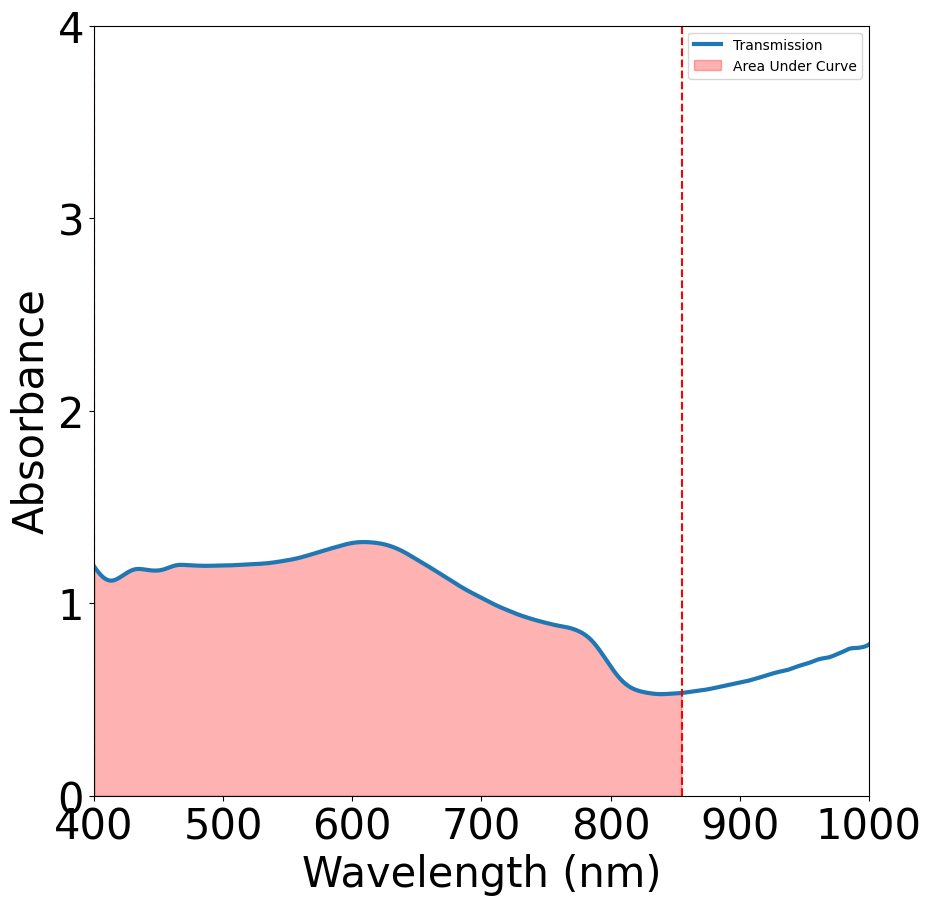

89 1
Area under the curve from 855 nm to 1000 nm: 89.75168059890419
Area under the curve from 400 nm to 855 nm: 1014.5504086865704


<ipython-input-44-79e6be608146>:50: RuntimeWarning: invalid value encountered in log10
  smooth_absorbance = -np.log10(smoothed_spectrum)


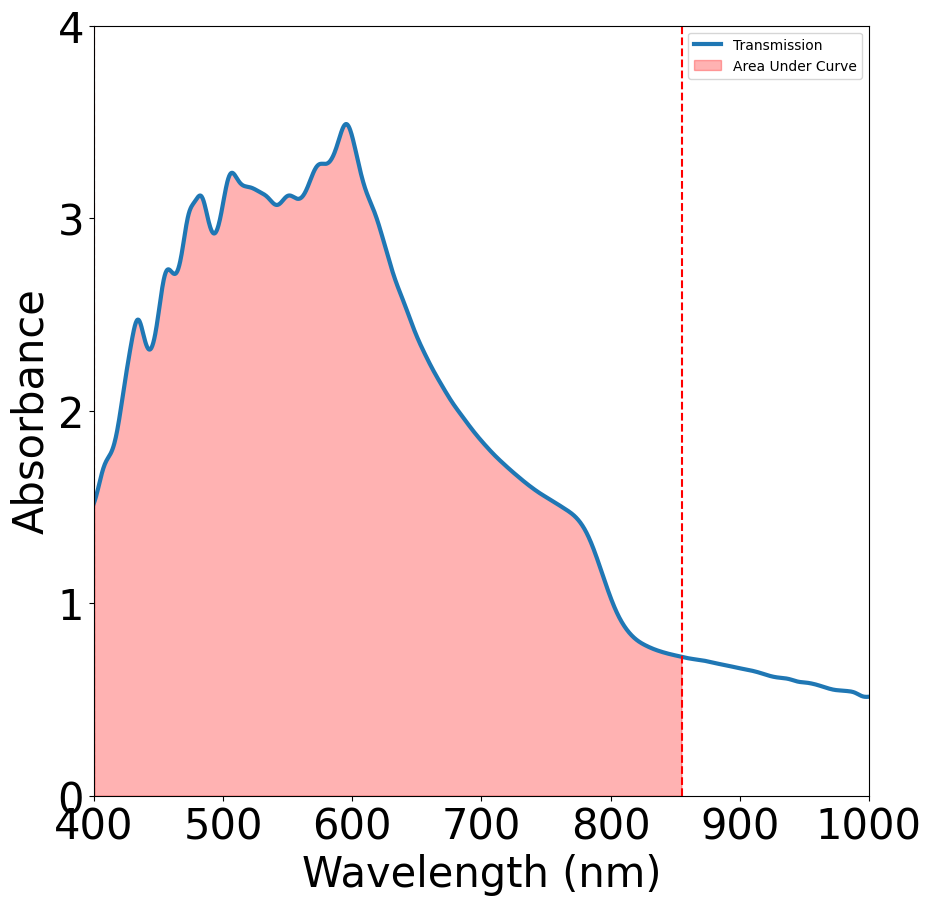

89 2
Area under the curve from 855 nm to 1000 nm: 34.53669226436679
Area under the curve from 400 nm to 855 nm: 668.7353987816073


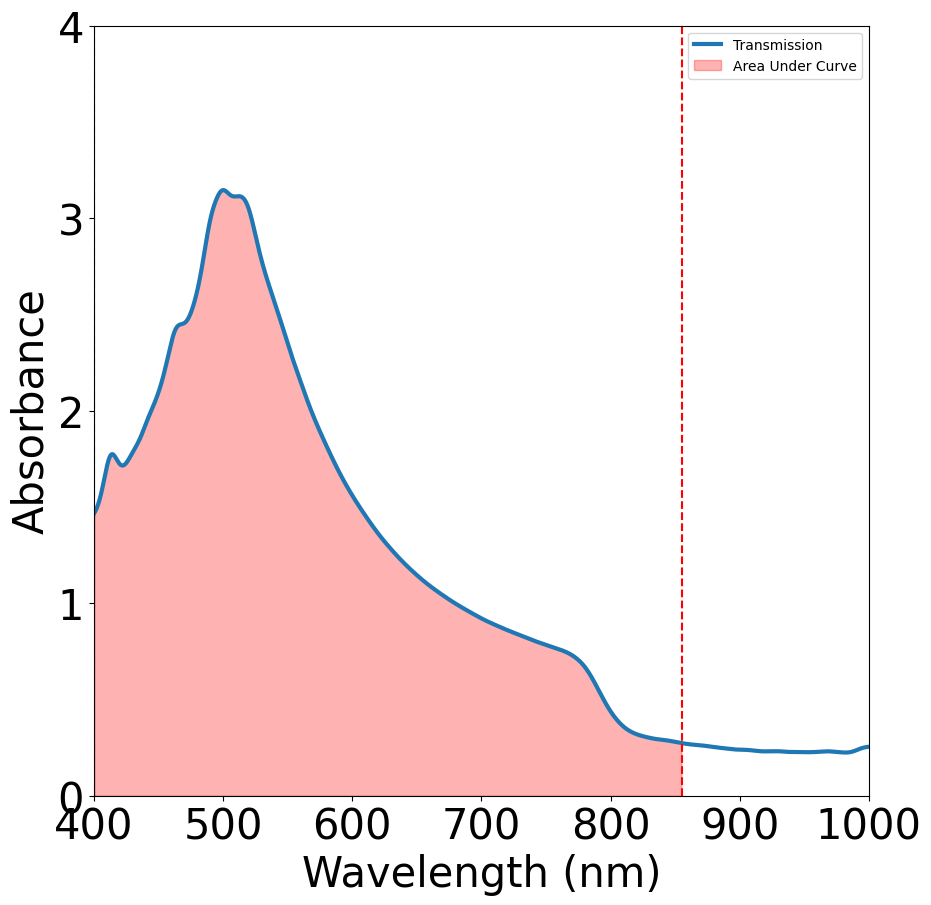

92 4
Area under the curve from 855 nm to 1000 nm: 20.577519215230087
Area under the curve from 400 nm to 855 nm: 595.1717791650096


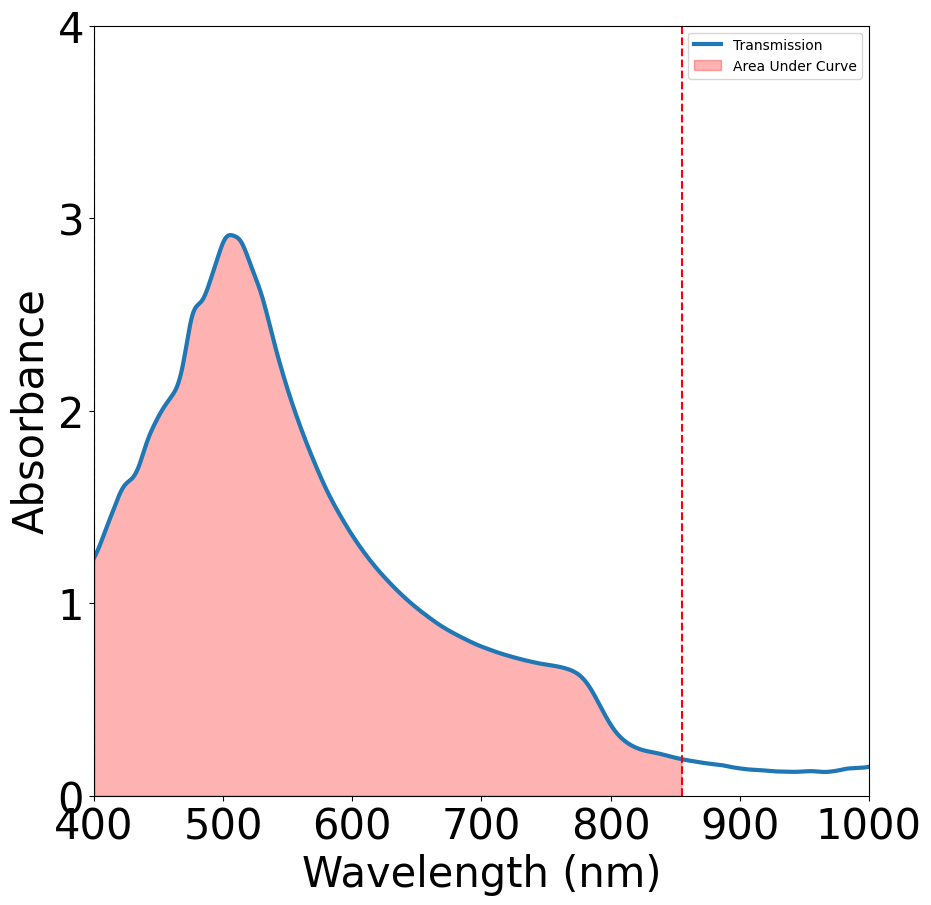

In [ ]:
label_size = 30

sigma = 15  # Adjust sigma for different levels of smoothing


# my_batches = np.array([75,76,74,81,82,80,77,83,68,68])
# my_samples = np.array([1,3,3,3,3,3,3,3,1,4])

my_batches = np.array([88, 89, 89, 92])
my_samples = np.array([1, 1, 2, 4])

plt.figure(figsize=(10, 10))

for i in range(len(my_batches)):
    b = my_batches[i]
    s = my_samples[i]

    print(b, s)
    batch = df[df["Batch No."] == b]
    sample = batch[batch["Sample #"] == str(s)]

    # print(f"Batch {b}, Sample {s}:")
    file_path = get_spec_run_filepath(sample)
    if not file_path:
        continue
    with h5py.File(file_path, "r") as hf:
        photo = hf["measurement/spec_run/photo"][:]
        wl_dark_int_time = hf["measurement/spec_run/wl_dark_int_time"][()]
        wl_dark_spectrum = hf["measurement/spec_run/wl_dark_spectrum"][:]
        wl_samp_int_times = hf["measurement/spec_run/wl_spectra_int_times"][:]
        wl_samp_spectrum = hf["measurement/spec_run/wl_spectra"][:]
        wl_ref_int_time = hf["measurement/spec_run/wl_ref_int_time"][()]
        wl_ref_spectrum = hf["measurement/spec_run/wl_ref_spectrum"][:]
        wl_wave_axis = hf["measurement/spec_run/wl_wls"][:]
        settings_gr = hf["app/settings"]
        sample_id = settings_gr.attrs["sample"]

        # print("File data has been read successfully.")
        sample_spectrum_corr = (
            wl_samp_spectrum / wl_samp_int_times.reshape((8, 1))
            - wl_dark_spectrum / wl_dark_int_time
        )
        sample_spectrum_corr_mean = np.mean(
            sample_spectrum_corr, axis=0
        )  # Average individual spectra per sample
        sample_spectrum_final = sample_spectrum_corr_mean / (
            wl_ref_spectrum / wl_ref_int_time - wl_dark_spectrum / wl_dark_int_time
        )  # Divide by the reference

        # Apply Gaussian smoothing
        smoothed_spectrum = gaussian_filter(sample_spectrum_final, sigma=sigma)

        # Calculate Absorbance
        smooth_absorbance = -np.log10(smoothed_spectrum)

        # ###########################################################################
        # # Limit data between 400 and 500 nm
        # mask = (wl_wave_axis >= 400) & (wl_wave_axis <= 500) # 855
        # x_selected = wl_wave_axis[mask]
        # y_selected = smooth_absorbance[mask]

        # # Area under the curve
        # area_under_curve = np.trapz(y_selected, x_selected)

        # print(f"Area under the curve from 400 nm to 500 nm: {area_under_curve}")

        ###########################################################################

        # Limit data between 855 and 1000 nm
        mask = (wl_wave_axis >= 855) & (wl_wave_axis <= 1000)  # 855
        x_selected = wl_wave_axis[mask]
        y_selected = smooth_absorbance[mask]

        # Area under the curve
        area_under_curve = np.trapz(y_selected, x_selected)

        print(f"Area under the curve from 855 nm to 1000 nm: {area_under_curve}")

        ###########################################################################

        # Limit data between 500 and 855 nm
        mask = (wl_wave_axis >= 400) & (wl_wave_axis <= 855)  # 855
        x_selected = wl_wave_axis[mask]
        y_selected = smooth_absorbance[mask]

        # Area under the curve
        area_under_curve = np.trapz(y_selected, x_selected)

        print(f"Area under the curve from 400 nm to 855 nm: {area_under_curve}")

        # Optionally, plot the curve with the selected region
        plt.figure(figsize=(10, 10))
        plt.plot(wl_wave_axis, smooth_absorbance, linewidth=3, label="Transmission")
        plt.fill_between(
            x_selected, y_selected, 0, color="red", alpha=0.3, label="Area Under Curve"
        )
        plt.xlim(400, 1000)
        plt.ylim(0, 4)
        plt.yticks([0, 1, 2, 3, 4])
        plt.axvline(400, color="r", linestyle="--")
        plt.axvline(855, color="r", linestyle="--")
        plt.xlabel("Wavelength (nm)", fontsize=label_size)
        plt.ylabel("Absorbance", fontsize=label_size)
        plt.tick_params(axis="both", which="major", labelsize=label_size)
        plt.legend()
        plt.show()

**Calculating Optimization Objective Metric**

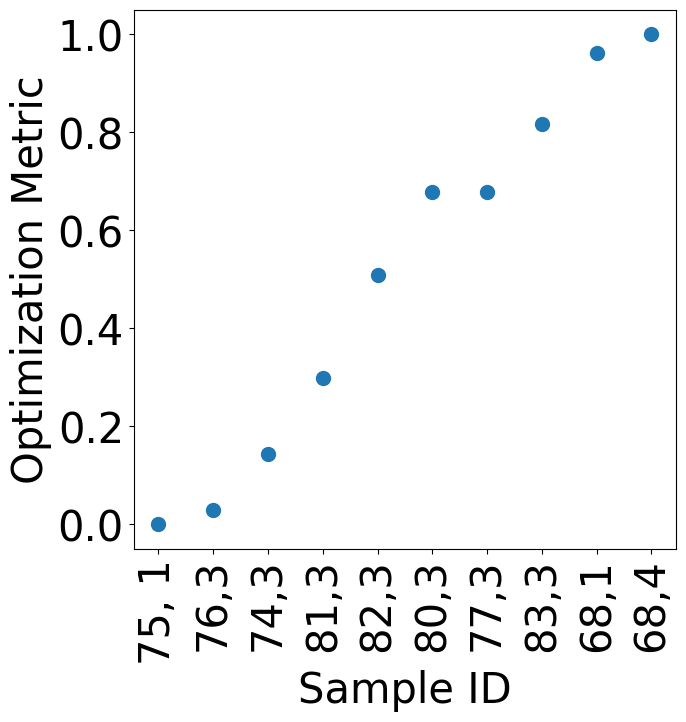

In [ ]:
from sklearn.preprocessing import MinMaxScaler

label_size = 30

sample_ID = [
    "75, 1",
    "76,3",
    "74,3",
    "81,3",
    "82,3",
    "80,3",
    "77,3",
    "83,3",
    "68,1",
    "68,4",
]

uv_area_original = np.array(
    [7.21, 13.22, 35.94, 67.11, 109.4, 143.6, 143.55, 171.64, 200.61, 208.27]
)

pl_intensity_original = np.array(
    [7.7e6, 4.8e6, 6.9e6, 12.0e6, 6.0e6, 5.1e6, 22.5e6, 1.4e6, 0.47e6, 14.5e6]
)

my_values_original = np.column_stack((uv_area_original, pl_intensity_original))


# Specified min and max values for each column
specified_min = np.min(my_values_original, axis=0)
specified_max = np.max(my_values_original, axis=0)

# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to your custom range
scaler.fit(np.vstack([specified_min, specified_max]))

# Transform your data based on the fitted scaler
my_values = scaler.transform(my_values_original)


uv_coefficient = 1
pl_coefficient = 0


my_objective = uv_coefficient * my_values[:, 0] + pl_coefficient * my_values[:, 1]

plt.figure(figsize=(7, 7))
plt.scatter(range(len(uv_area_original)), my_objective, s=100)
plt.xlabel("Sample ID", fontsize=label_size)
plt.ylabel("Optimization Metric", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
# Setting custom x-axis ticks
plt.xticks(
    ticks=range(len(sample_ID)), labels=sample_ID, fontsize=label_size, rotation=90
)

plt.show()

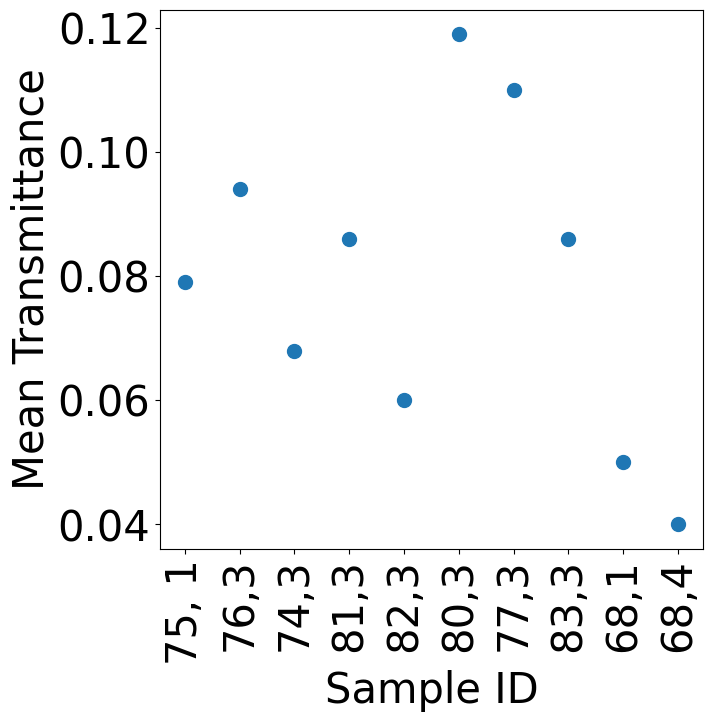

In [ ]:
my_mean_transmittance = np.array(
    [0.079, 0.094, 0.068, 0.086, 0.06, 0.119, 0.11, 0.086, 0.05, 0.04]
)

plt.figure(figsize=(7, 7))
plt.scatter(range(len(my_mean_transmittance)), my_mean_transmittance, s=100)
plt.xlabel("Sample ID", fontsize=label_size)
plt.ylabel("Mean Transmittance", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
# Setting custom x-axis ticks
plt.xticks(
    ticks=range(len(sample_ID)), labels=sample_ID, fontsize=label_size, rotation=90
)

plt.show()

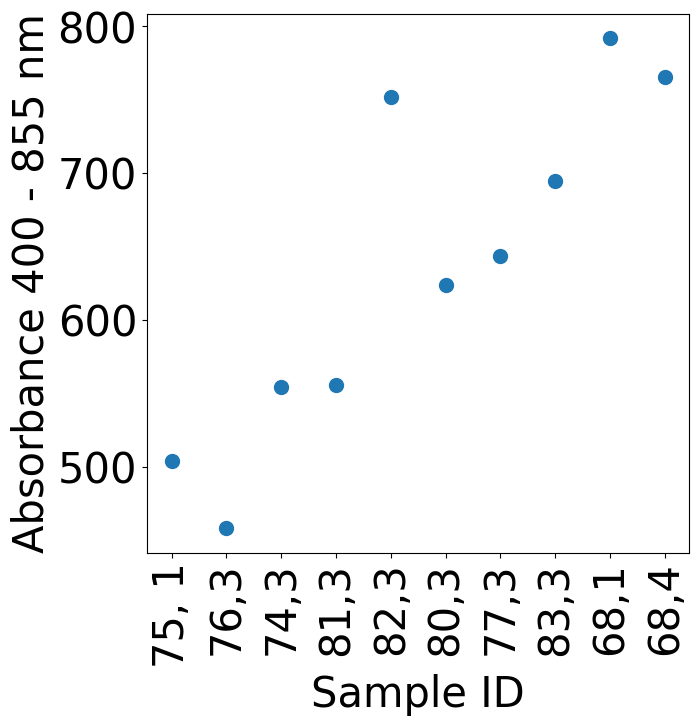

In [ ]:
area_absorbance_2 = np.array(
    [503.59, 457.86, 554.48, 555.54, 751.91, 623.86, 643.45, 694.61, 791.90, 765.31]
)

area_absorbance_3 = np.array(
    [115.94, 98.33, 97.39, 88.98, 48.35, 37.38, 29.46, 31.53, 26.88, 25.79]
)

sample_ID = [
    "75, 1",
    "76,3",
    "74,3",
    "81,3",
    "82,3",
    "80,3",
    "77,3",
    "83,3",
    "68,1",
    "68,4",
]


plt.figure(figsize=(7, 7))
plt.scatter(range(len(area_absorbance_2)), area_absorbance_2, s=100)
plt.xlabel("Sample ID", fontsize=label_size)
plt.ylabel("Absorbance 400 - 855 nm", fontsize=label_size)
plt.tick_params(axis="both", which="major", labelsize=label_size)
# Setting custom x-axis ticks
plt.xticks(
    ticks=range(len(sample_ID)), labels=sample_ID, fontsize=label_size, rotation=90
)

plt.show()